
▶️  SARIMAX Load-Only | Horizon: 24h | Anchor: 2023-03-21
Training points: 15793, Testing points: 24
Saved CSV: sarimax_loadonly_forecast_24h_2023-03-21.csv


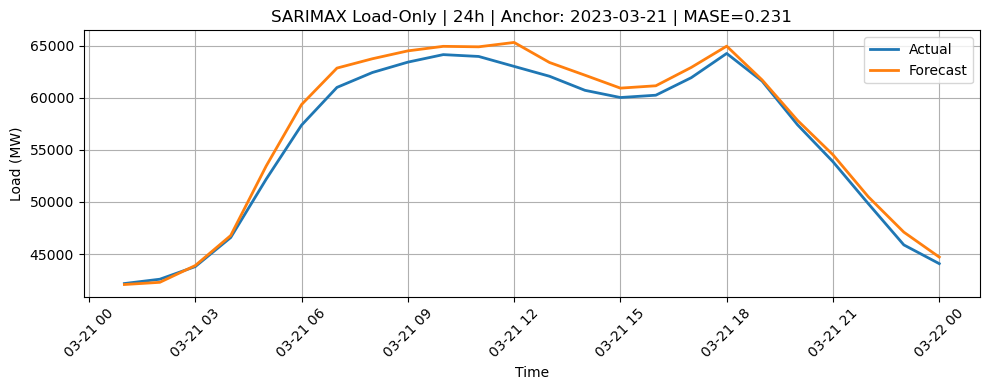


▶️  SARIMAX Load-Only | Horizon: 7d | Anchor: 2023-03-21
Training points: 15793, Testing points: 168
Saved CSV: sarimax_loadonly_forecast_7d_2023-03-21.csv


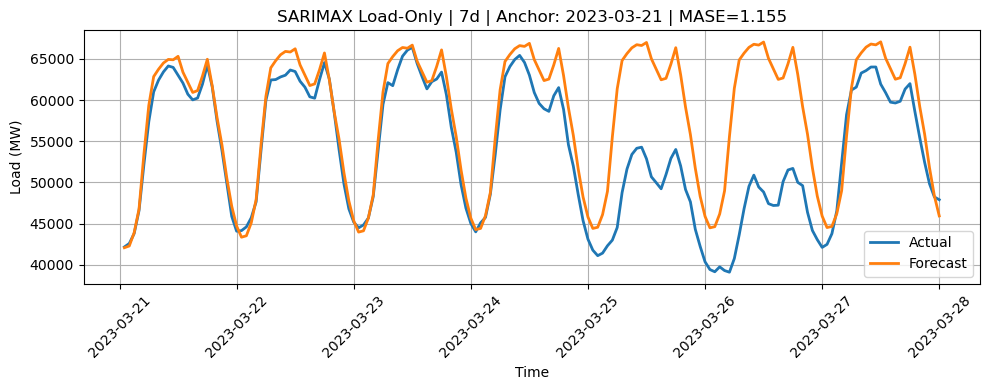


▶️  SARIMAX Load-Only | Horizon: 24h | Anchor: 2023-06-21
Training points: 18001, Testing points: 24
Saved CSV: sarimax_loadonly_forecast_24h_2023-06-21.csv


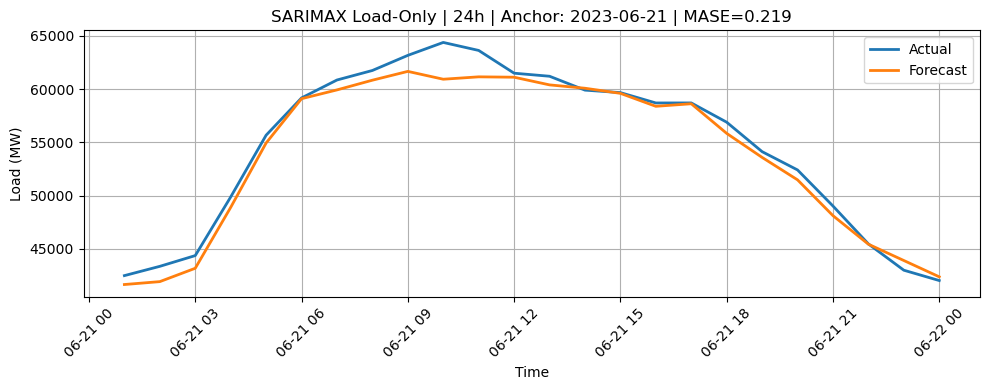


▶️  SARIMAX Load-Only | Horizon: 7d | Anchor: 2023-06-21
Training points: 18001, Testing points: 168
Saved CSV: sarimax_loadonly_forecast_7d_2023-06-21.csv


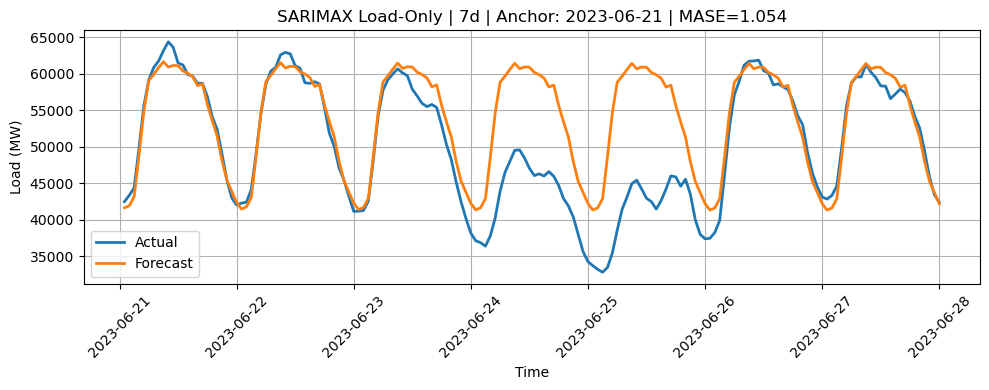


▶️  SARIMAX Load-Only | Horizon: 24h | Anchor: 2023-12-21
Training points: 22393, Testing points: 24
Saved CSV: sarimax_loadonly_forecast_24h_2023-12-21.csv


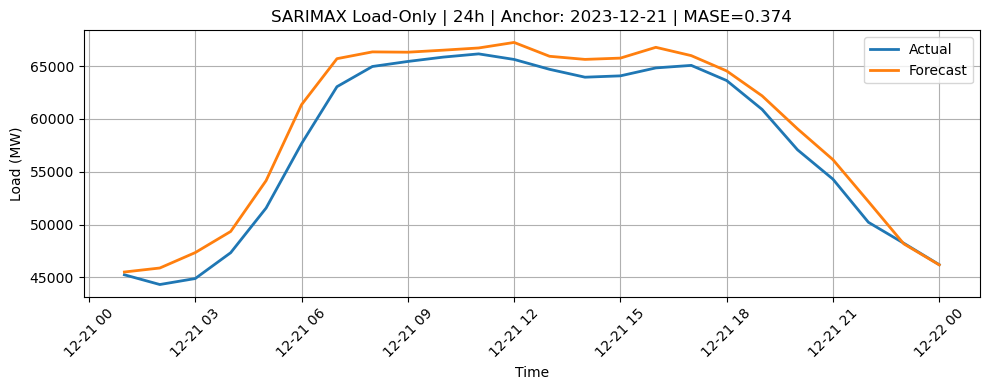


▶️  SARIMAX Load-Only | Horizon: 7d | Anchor: 2023-12-21
Training points: 22393, Testing points: 168
Saved CSV: sarimax_loadonly_forecast_7d_2023-12-21.csv


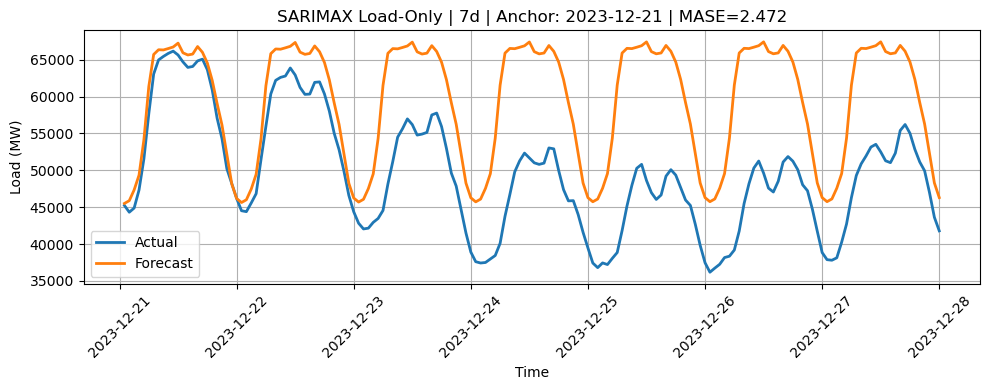


✅ Saved combined results to sarimax_loadonly_summary_all_anchors.csv
       Anchor Horizon          MAE     MAE_CI_L      MAE_CI_U          RMSE  \
0  2023-03-21     24h   923.923499   697.872719   1148.492029   1092.889268   
1  2023-03-21      7d  4617.475809  3843.436167   5438.381650   7031.298699   
2  2023-06-21     24h   877.431604   607.861164   1209.332034   1166.612681   
3  2023-06-21      7d  4227.592172  3432.209864   5094.050761   6844.318800   
4  2023-12-21     24h  1494.166676  1167.501044   1842.216676   1726.410220   
5  2023-12-21      7d  9862.913584  8909.463224  10820.974859  11620.163311   

      RMSE_CI_L     RMSE_CI_U      MASE  MASE_CI_L  MASE_CI_U  Runtime (s)  
0    843.065017   1308.566666  0.231018   0.174497   0.287170     4.450531  
1   5973.318099   7961.023130  1.154557   0.961015   1.359816     4.453823  
2    749.860126   1595.646368  0.218798   0.151577   0.301561     4.309536  
3   5818.537882   7881.045913  1.054199   0.855861   1.270260     4.

In [1]:
##SARIMAX LOAD ONLY

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")

# ─── Constants ───────────────────────────────────────────────────────────────
LOAD_PATH = "updated_load_data_with_german_holidays.csv"
HORIZONS  = {"24h": 24, "7d": 168}
ANCHORS   = [
    pd.Timestamp("2023-03-21 00:00:00"),
    pd.Timestamp("2023-06-21 00:00:00"),
    pd.Timestamp("2023-12-21 00:00:00"),
]

# ─── 1. Load data ────────────────────────────────────────────────────────────
def load_data():
    df = (
        pd.read_csv(LOAD_PATH, parse_dates=["Time"])
          .assign(Time=lambda d: d["Time"].dt.tz_localize(None))
          .set_index("Time")
          .asfreq("H")
          .rename(columns={"Actual Load": "y"})[["y"]]
    )
    return df.reset_index().rename(columns={"Time": "ds"})

# ─── 2. Evaluation ───────────────────────────────────────────────────────────
def evaluate(y_true, y_pred, y_train):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mase_val = mase(y_true, y_pred, y_train.values, m=24)
    return mae, rmse, mase_val

def mase(y_true, y_pred, y_train, m=24):
    """
    Mean Absolute Scaled Error:
      numerator   = mean(|y_t - ŷ_t|)
      denominator = mean(|y_t - y_{t-m}|) on the TRAINING series
    """
    n = len(y_true)
    # 1) Numerator: mean absolute forecast error on test
    mae = np.mean(np.abs(y_true - y_pred))
    # 2) Denominator: in-sample one-step seasonal naïve errors
    denom = np.mean(
        np.abs(y_train[m:] - y_train[:-m])
    )
    return mae / denom

def bootstrap_metrics(y_true, y_pred, y_train, n_boot=1000, ci=95):
    rng = np.random.default_rng(seed=42)
    mae_list, rmse_list, mase_list = [], [], []

    for _ in range(n_boot):
        idx = rng.choice(len(y_true), size=len(y_true), replace=True)
        yt, yp = y_true[idx], y_pred[idx]
        mae_list.append(mean_absolute_error(yt, yp))
        rmse_list.append(np.sqrt(mean_squared_error(yt, yp)))
        # note: denominator fixed across resamples, use full y_train
        mase_list.append(mase(yt, yp, y_train.values, m=24))

    lower = (100 - ci) / 2
    upper = 100 - lower
    return {
        "MAE_CI":  (np.percentile(mae_list, lower),   np.percentile(mae_list, upper)),
        "RMSE_CI": (np.percentile(rmse_list, lower),  np.percentile(rmse_list, upper)),
        "MASE_CI": (np.percentile(mase_list, lower),  np.percentile(mase_list, upper)),
    }


# ─── 3. Main ─────────────────────────────────────────────────────────────────
def main():
    data = load_data()
    all_results = []

    for anchor in ANCHORS:
        for label, h in HORIZONS.items():
            print(f"\n▶️  SARIMAX Load-Only | Horizon: {label} | Anchor: {anchor.date()}")
            train_df = data[data["ds"] <= anchor].copy()
            train_df = train_df.set_index("ds")
            train_df["y"] = train_df["y"].interpolate(method="time").fillna(method="bfill")
            train_df = train_df.reset_index()
            test_end = anchor + timedelta(hours=h)
            test_df  = data[(data["ds"] > anchor) & (data["ds"] <= test_end)].copy()
            n_steps  = len(test_df)

            print(f"Training points: {len(train_df)}, Testing points: {n_steps}")

            # Fit SARIMAX
            start = time.time()
            model = SARIMAX(
                train_df["y"],
                order=(1, 0, 1),
                seasonal_order=(0, 1, 0, 24),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False, maxiter=200)
            forecast = model.get_forecast(steps=n_steps).predicted_mean
            duration = time.time() - start

            # Evaluate
            mask   = ~test_df["y"].isna()
            y_true = test_df.loc[mask, "y"].values
            y_pred = forecast.loc[test_df.index[mask]].values

            mae, rmse, mase_val = evaluate(y_true, y_pred, train_df["y"])
            ci = bootstrap_metrics(y_true, y_pred, train_df["y"])

        
            all_results.append({
                "Anchor":      anchor.date(),
                "Horizon":     label,
                "MAE":          mae,
                "MAE_CI_L":    ci["MAE_CI"][0],
                "MAE_CI_U":    ci["MAE_CI"][1],
                "RMSE":         rmse,
                "RMSE_CI_L":   ci["RMSE_CI"][0],
                "RMSE_CI_U":   ci["RMSE_CI"][1],
                "MASE":        mase_val,
                "MASE_CI_L":   ci["MASE_CI"][0],
                "MASE_CI_U":   ci["MASE_CI"][1],
                "Runtime (s)": duration
            })

            # Save CSV
            export_df = pd.DataFrame({
                "timestamp": test_df.loc[mask, "ds"].values,
                "actual": y_true,
                "sarimax_loadonly_forecast": y_pred
            })
            csv_path = f"sarimax_loadonly_forecast_{label}_{anchor.date()}.csv"
            export_df.to_csv(csv_path, index=False)
            print(f"Saved CSV: {csv_path}")

            # Save plot
            plt.figure(figsize=(10, 4))
            plt.plot(test_df.loc[mask, "ds"], y_true, label="Actual", lw=2)
            plt.plot(test_df.loc[mask, "ds"], y_pred, label="Forecast", lw=2)
            plt.title(f"SARIMAX Load-Only | {label} | Anchor: {anchor.date()} | MASE={mase_val:.3f}")
            plt.xlabel("Time"); plt.ylabel("Load (MW)")
            plt.legend(); plt.grid(); plt.xticks(rotation=45); plt.tight_layout()
            plot_path = f"sarimax_loadonly_plot_{label}_{anchor.date()}.png"
            plt.savefig(plot_path)
            plt.show()

    # Save combined summary
    summary_df = pd.DataFrame(all_results)
    summary_df.to_csv("sarimax_loadonly_summary_all_anchors.csv", index=False)
    print("\n✅ Saved combined results to sarimax_loadonly_summary_all_anchors.csv")
    print(summary_df)

if __name__ == "__main__":
    main()



▶️  SARIMAX+Exog | 24h | Anchor: 2023-03-21 | MASE=0.133
Training points: 6308, Testing points: 24
MAE  = 510.63  CI: [345.67, 676.47]
RMSE = 648.69  CI: [448.94, 816.48]
MASE = 0.133  CI: [0.090, 0.176]



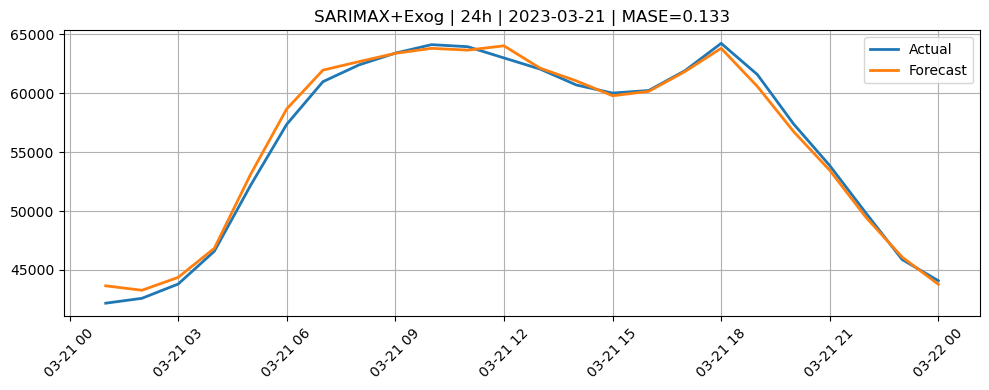


▶️  SARIMAX+Exog | 7d | Anchor: 2023-03-21 | MASE=0.477
Training points: 6308, Testing points: 168
MAE  = 1831.00  CI: [1536.71, 2116.87]
RMSE = 2684.25  CI: [2220.92, 3115.80]
MASE = 0.477  CI: [0.401, 0.552]



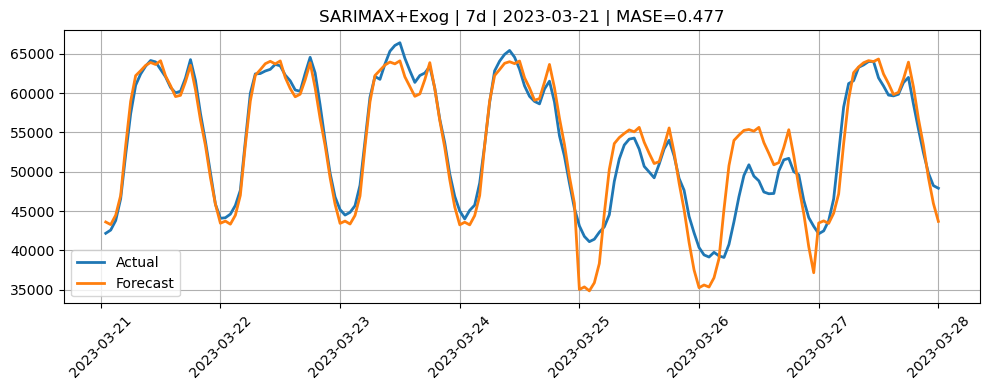


▶️  SARIMAX+Exog | 24h | Anchor: 2023-06-21 | MASE=0.198
Training points: 8516, Testing points: 24
MAE  = 774.24  CI: [532.80, 1078.96]
RMSE = 1048.17  CI: [634.20, 1475.41]
MASE = 0.198  CI: [0.137, 0.277]



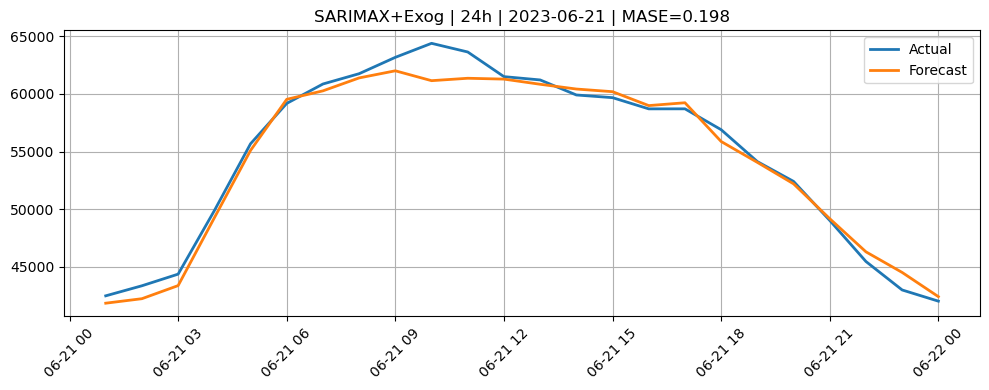


▶️  SARIMAX+Exog | 7d | Anchor: 2023-06-21 | MASE=0.554
Training points: 8516, Testing points: 168
MAE  = 2162.92  CI: [1844.34, 2555.15]
RMSE = 3156.48  CI: [2676.22, 3695.71]
MASE = 0.554  CI: [0.473, 0.655]



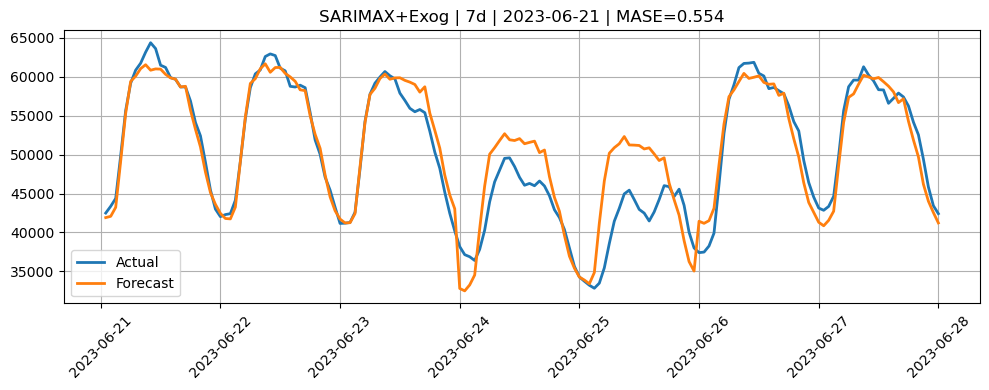


▶️  SARIMAX+Exog | 24h | Anchor: 2023-12-21 | MASE=0.531
Training points: 12908, Testing points: 24
MAE  = 2072.70  CI: [1724.39, 2406.05]
RMSE = 2250.57  CI: [1939.57, 2550.78]
MASE = 0.531  CI: [0.442, 0.616]



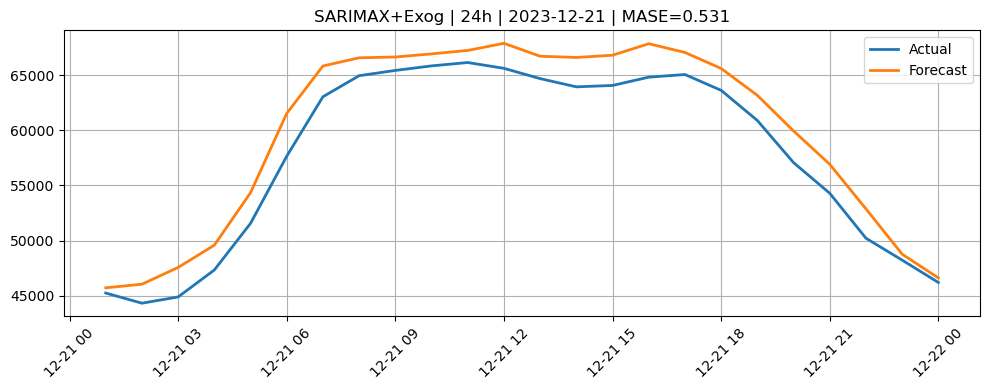


▶️  SARIMAX+Exog | 7d | Anchor: 2023-12-21 | MASE=2.729
Training points: 12908, Testing points: 168
MAE  = 10653.45  CI: [9735.99, 11622.09]
RMSE = 12294.18  CI: [11396.00, 13177.41]
MASE = 2.729  CI: [2.494, 2.977]



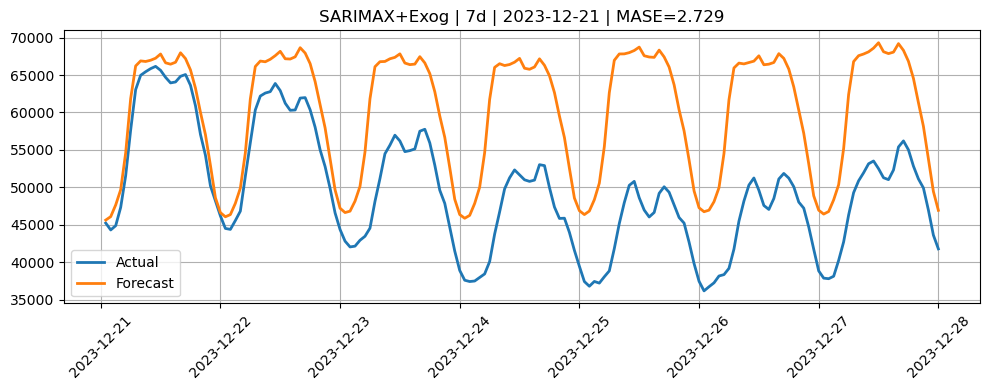


✅ Saved combined summary to sarimax_exog_summary_all_anchors.csv
    Anchor Horizon          MAE    MAE_CI_L     MAE_CI_U         RMSE    RMSE_CI_L    RMSE_CI_U     MASE  MASE_CI_L  MASE_CI_U  Runtime (s)
2023-03-21     24h   510.628930  345.672913   676.469647   648.687711   448.941102   816.476986 0.133100   0.090103   0.176328    13.727316
2023-03-21      7d  1831.004270 1536.710541  2116.868963  2684.250969  2220.924489  3115.796373 0.477267   0.400557   0.551780    13.471747
2023-06-21     24h   774.236394  532.804166  1078.962116  1048.170148   634.197078  1475.414118 0.198428   0.136552   0.276525     9.814281
2023-06-21      7d  2162.919576 1844.344562  2555.150056  3156.476819  2676.216758  3695.712514 0.554331   0.472684   0.654855     9.808778
2023-12-21     24h  2072.698995 1724.387646  2406.052524  2250.569916  1939.573546  2550.780589 0.530976   0.441747   0.616374   206.089778
2023-12-21      7d 10653.454760 9735.986208 11622.086648 12294.183408 11395.995105 13177.40671

In [2]:
##SARIMAX LOAD + EXOG

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

# ─── Constants ───────────────────────────────────────────────────────────────
LOAD_PATH    = "updated_load_data_with_german_holidays.csv"
WEATHER_PATH = "Germany_average_temperature_humidity_2022_2024.csv"
HORIZONS     = {"24h": 24, "7d": 168}
ANCHORS      = [
    pd.Timestamp("2023-03-21 00:00:00"),
    pd.Timestamp("2023-06-21 00:00:00"),
    pd.Timestamp("2023-12-21 00:00:00"),
]

# ─── 1. Load & preprocess ────────────────────────────────────────────────────
def load_data():
    # No global interpolation—missing y's remain for SARIMAX to handle
    ld = (
        pd.read_csv(LOAD_PATH, parse_dates=["Time"])
          .assign(Time=lambda d: d["Time"].dt.tz_localize(None))
          .set_index("Time").asfreq("H")
          .rename(columns={"Actual Load": "y"})[["y"]]
    )
    w = (
        pd.read_csv(WEATHER_PATH, parse_dates=["DateTime"])
          .assign(DateTime=lambda d: d["DateTime"].dt.tz_localize(None))
          .set_index("DateTime").asfreq("H")
          .rename(columns={"AverageTemperature":"temp_fc","AverageHumidity":"hum_fc"})
    )
    return ld.reset_index().rename(columns={"Time":"ds"}), w

# ─── 2. Forecast weather & add noise ────────────────────────────────────────
def add_realistic_weather_forecast_errors(fc_t, fc_h, h):
    base_t, base_h = 0.8, 3.0; growth, ar = 0.15, 0.85
    te = np.zeros(h); he = np.zeros(h)
    for i in range(h):
        st = base_t*(1+growth*(i/24)); sh = base_h*(1+growth*(i/24))
        if i==0:
            te[i] = np.random.normal(0,st); he[i] = np.random.normal(0,sh)
        else:
            te[i] = ar*te[i-1] + np.random.normal(0, st*np.sqrt(1-ar**2))
            he[i] = ar*he[i-1] + np.random.normal(0, sh*np.sqrt(1-ar**2))
    hours = np.arange(h)%24
    diurnal = 0.4*np.sin(2*np.pi*(hours-10)/24)
    return fc_t+te+diurnal, fc_h+he

def forecast_weather(w, anchor, h):
    order,seas = (1,0,1),(1,0,1,24)
    wt = w[w.index<=anchor]
    m_t = SARIMAX(wt["temp_fc"], order=order, seasonal_order=seas,
                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    m_h = SARIMAX(wt["hum_fc"], order=order, seasonal_order=seas,
                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    idx = pd.date_range(anchor+pd.Timedelta(hours=1),periods=h,freq="H")
    t_fc = m_t.get_forecast(h).predicted_mean.values
    h_fc = m_h.get_forecast(h).predicted_mean.values
    t_no, h_no = add_realistic_weather_forecast_errors(t_fc,h_fc,h)
    df = pd.DataFrame({"temp_fc":t_no,"hum_fc":h_no}, index=idx)
    df.index.name="ds"
    return df

# ─── 3. Feature engineering ─────────────────────────────────────────────────
def engineer_features(w_train, w_fc):
    df = w_train.copy()
    df["temp_diff_3h"]   = df["temp_fc"] - df["temp_fc"].shift(3)
    df["temp_roll_6h"]   = df["temp_fc"].rolling(6).mean()
    df["hum_roll_6h"]    = df["hum_fc"].rolling(6).mean()
    df["temp_x_hum"]     = df["temp_fc"]*df["hum_fc"]
    df["heating_demand"] = np.clip(18-df["temp_fc"],0,None)
    df["cooling_demand"] = np.clip(df["temp_fc"]-18,0,None)
    df["is_weekend"]     = df.index.dayofweek.isin([5,6]).astype(int)
    feats_train = df.dropna()

    hist = w_train.rename_axis("ds")
    td,tr,hr = [],[],[]
    for i,(_,row) in enumerate(w_fc.iterrows()):
        prev = hist["temp_fc"].iloc[-(3-i)] if i<3 else w_fc["temp_fc"].iloc[i-3]
        td.append(row["temp_fc"]-prev)
        seq_t = list(hist["temp_fc"].iloc[-5:]) + list(w_fc["temp_fc"].iloc[:i+1])
        seq_h = list(hist["hum_fc"].iloc[-5:])  + list(w_fc["hum_fc"].iloc[:i+1])
        tr.append(np.mean(seq_t[-6:])); hr.append(np.mean(seq_h[-6:]))
    feats_test = w_fc.assign(
        temp_diff_3h=td, temp_roll_6h=tr, hum_roll_6h=hr,
        temp_x_hum=w_fc["temp_fc"]*w_fc["hum_fc"],
        heating_demand=np.clip(18-w_fc["temp_fc"],0,None),
        cooling_demand=np.clip(w_fc["temp_fc"]-18,0,None),
        is_weekend=w_fc.index.dayofweek.isin([5,6]).astype(int)
    )
    return feats_train, feats_test

def merge_and_slice(ld, feats_tr, feats_te, anchor, h):
    # no cross-boundary interpolation here
    feats_tr.index.name = feats_te.index.name = "ds"
    all_feats = pd.concat([feats_tr, feats_te]).reset_index()
    train_ld = ld[ld["ds"]<=anchor]
    test_ld  = ld[(ld["ds"]>anchor)&(ld["ds"]<=anchor+pd.Timedelta(hours=h))]
    df_all = pd.merge(pd.concat([train_ld, test_ld]), all_feats, on="ds", how="inner")
    train = df_all[df_all["ds"]<=anchor]
    test  = df_all[(df_all["ds"]>anchor)&(df_all["ds"]<=anchor+pd.Timedelta(hours=h))]
    return train, test

# ─── 4. Error metrics (MASE) ─────────────────────────────────────────────────
def mase(y_true, y_pred, y_train, m=24):
    num = np.mean(np.abs(y_true - y_pred))
    den = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    return num / den

def evaluate(y_true, y_pred, y_train):
    mae     = mean_absolute_error(y_true, y_pred)
    rmse    = np.sqrt(mean_squared_error(y_true, y_pred))
    mase_val = mase(y_true, y_pred, y_train.values, m=24)
    return mae, rmse, mase_val

def bootstrap_metrics(y_true, y_pred, y_train, n_boot=1000, ci=95):
    rng = np.random.default_rng(42)
    mae_list, rmse_list, mase_list = [], [], []
    for _ in range(n_boot):
        idx = rng.choice(len(y_true), size=len(y_true), replace=True)
        yt, yp = y_true[idx], y_pred[idx]
        mae_list.append(mean_absolute_error(yt, yp))
        rmse_list.append(np.sqrt(mean_squared_error(yt, yp)))
        mase_list.append(mase(yt, yp, y_train.values, m=24))
    lo, hi = (100-ci)/2, 100-(100-ci)/2
    return {
        "MAE_CI":  (np.percentile(mae_list, lo), np.percentile(mae_list, hi)),
        "RMSE_CI": (np.percentile(rmse_list, lo), np.percentile(rmse_list, hi)),
        "MASE_CI": (np.percentile(mase_list, lo), np.percentile(mase_list, hi)),
    }

# ─── 5. Main loop ────────────────────────────────────────────────────────────
def main():
    ld, w = load_data()
    all_results = []

    for anchor in ANCHORS:
        for label, h in HORIZONS.items():
            # 1) forecast weather + engineer features + merge
            w_fc       = forecast_weather(w, anchor, h)
            feats_tr, feats_te = engineer_features(w[w.index<=anchor], w_fc)
            train_df, test_df  = merge_and_slice(ld, feats_tr, feats_te, anchor, h)
            train_df = train_df.set_index("ds")
            # interpolate the two (or fewer) missing y’s in-sample only, then back to a column
            train_df["y"] = train_df["y"].interpolate(method="time").fillna(method="bfill")
            train_df = train_df.reset_index()

            # 2) fill exogs separately by median
            exogs = ["temp_fc","hum_fc","temp_diff_3h","temp_roll_6h",
                     "hum_roll_6h","temp_x_hum","heating_demand",
                     "cooling_demand","is_weekend"]
            for c in exogs:
                med = train_df[c].median()
                train_df[c].fillna(med, inplace=True)
                test_df[c].fillna(med, inplace=True)

            # 3) fit & forecast
            start = time.time()
            mod = SARIMAX(
                train_df["y"], exog=train_df[exogs],
                order=(1,0,1), seasonal_order=(0,1,0,24),
                enforce_stationarity=False,enforce_invertibility=False
            ).fit(disp=False, maxiter=200)
            fc = mod.get_forecast(steps=len(test_df), exog=test_df[exogs]).predicted_mean
            runtime = time.time()-start

            # 4) eval + CI using MASE
            mask   = ~test_df["y"].isna()
            y_true = test_df.loc[mask, "y"].values
            y_pred = fc.loc[test_df.index[mask]].values

            mae, rmse, mase_val = evaluate(y_true, y_pred, train_df["y"])
            ci = bootstrap_metrics(y_true, y_pred, train_df["y"])
            
            print(f"\n▶️  SARIMAX+Exog | {label} | Anchor: {anchor.date()} | "
                f"MASE={mase_val:.3f}")
            print(f"Training points: {len(train_df)}, Testing points: {len(test_df)}")
            print(f"MAE  = {mae:.2f}  CI: [{ci['MAE_CI'][0]:.2f}, {ci['MAE_CI'][1]:.2f}]")
            print(f"RMSE = {rmse:.2f}  CI: [{ci['RMSE_CI'][0]:.2f}, {ci['RMSE_CI'][1]:.2f}]")
            print(f"MASE = {mase_val:.3f}  CI: [{ci['MASE_CI'][0]:.3f}, {ci['MASE_CI'][1]:.3f}]\n")

            all_results.append({
                "Anchor":    anchor.date(),
                "Horizon":   label,
                "MAE":       mae,
                "MAE_CI_L":  ci["MAE_CI"][0],"MAE_CI_U": ci["MAE_CI"][1],
                "RMSE":      rmse,
                "RMSE_CI_L": ci["RMSE_CI"][0],"RMSE_CI_U":ci["RMSE_CI"][1],
                "MASE":      mase_val,
                "MASE_CI_L": ci["MASE_CI"][0],"MASE_CI_U":ci["MASE_CI"][1],
                "Runtime (s)": runtime
            })

            # 5) output & plot with MASE title
            out_df = pd.DataFrame({
                "timestamp": test_df.loc[mask, "ds"],
                "actual":    y_true,
                "forecast":  y_pred
            })
            out_df.to_csv(f"sarimax_exog_forecast_{label}_{anchor.date()}.csv", index=False)

            plt.figure(figsize=(10,4))
            plt.plot(out_df["timestamp"], out_df["actual"], label="Actual", lw=2)
            plt.plot(out_df["timestamp"], out_df["forecast"], label="Forecast", lw=2)
            plt.title(f"SARIMAX+Exog | {label} | {anchor.date()} | MASE={mase_val:.3f}")
            plt.xticks(rotation=45); plt.grid(True); plt.legend(); plt.tight_layout()
            plt.savefig(f"sarimax_exog_plot_{label}_{anchor.date()}.png")
            plt.show()

    summary = pd.DataFrame(all_results)
    summary.to_csv("sarimax_exog_summary_all_anchors.csv", index=False)
    # force pandas to dump the entire DataFrame
    print("\n✅ Saved combined summary to sarimax_exog_summary_all_anchors.csv")
    print(summary.to_string(index=False))


if __name__ == "__main__":
    main()



▶️  SARIMAX+Weekend | 24h | Anchor: 2023-03-21 | MASE=0.158
Training points: 6308, Testing points: 24
MAE  = 604.58  CI: [445.71, 762.71]
RMSE = 719.48  CI: [560.03, 866.68]
MASE = 0.158  CI: [0.116, 0.199]



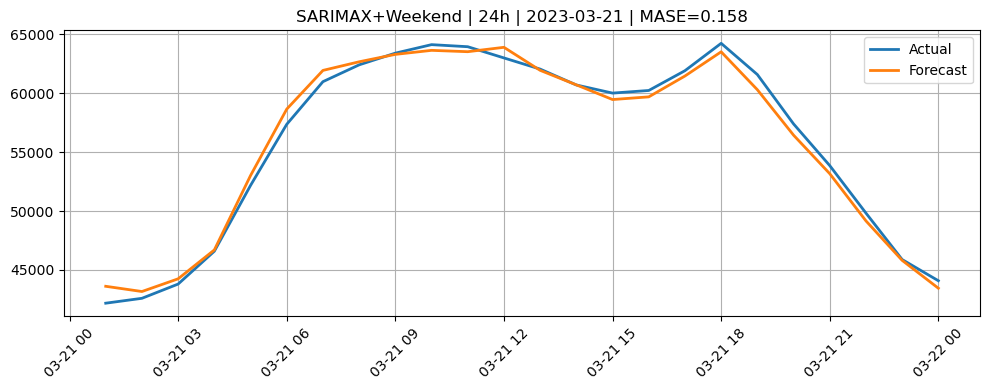


▶️  SARIMAX+Weekend | 7d | Anchor: 2023-03-21 | MASE=0.479
Training points: 6308, Testing points: 168
MAE  = 1837.87  CI: [1541.09, 2126.87]
RMSE = 2662.51  CI: [2232.52, 3051.71]
MASE = 0.479  CI: [0.402, 0.554]



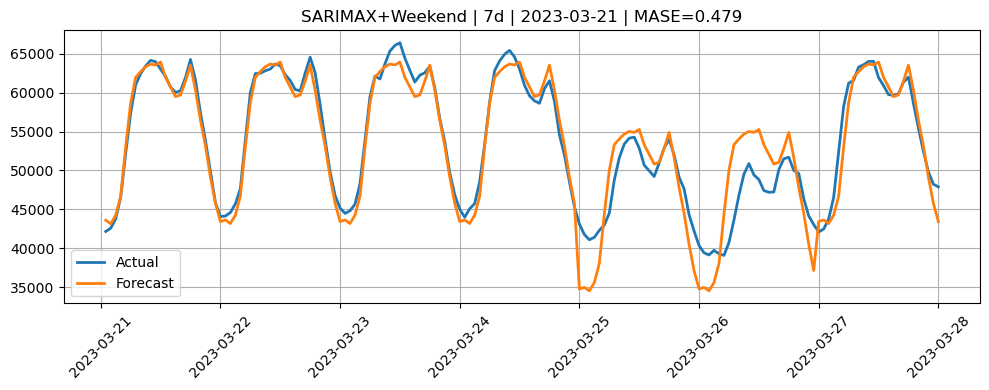


▶️  SARIMAX+Weekend | 24h | Anchor: 2023-06-21 | MASE=0.194
Training points: 8516, Testing points: 24
MAE  = 755.37  CI: [513.87, 1060.13]
RMSE = 1027.33  CI: [620.59, 1456.03]
MASE = 0.194  CI: [0.132, 0.272]



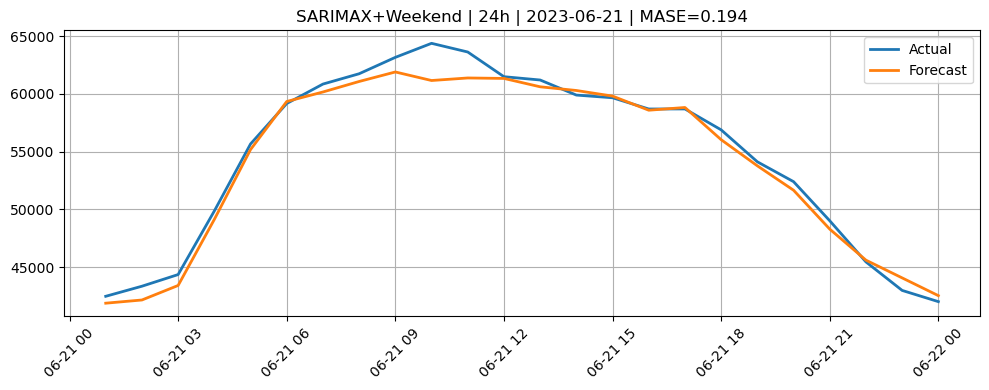


▶️  SARIMAX+Weekend | 7d | Anchor: 2023-06-21 | MASE=0.591
Training points: 8516, Testing points: 168
MAE  = 2306.76  CI: [1936.12, 2726.09]
RMSE = 3458.53  CI: [2904.38, 4055.66]
MASE = 0.591  CI: [0.496, 0.699]



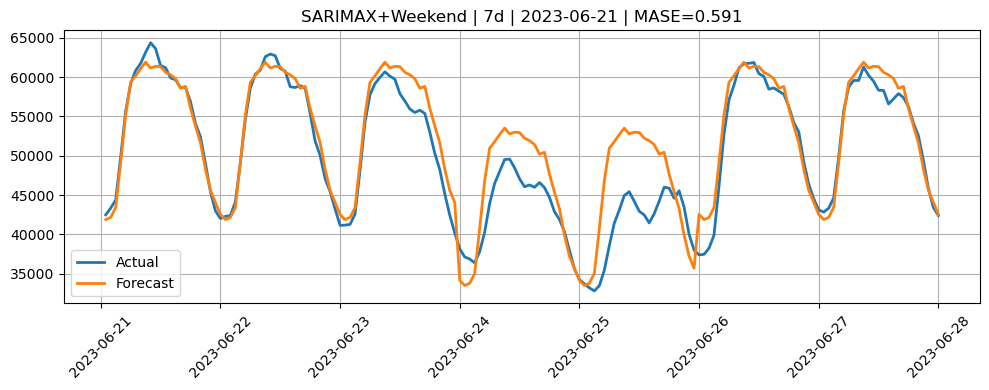


▶️  SARIMAX+Weekend | 24h | Anchor: 2023-12-21 | MASE=0.357
Training points: 12908, Testing points: 24
MAE  = 1394.87  CI: [1086.90, 1732.70]
RMSE = 1625.20  CI: [1288.07, 1973.13]
MASE = 0.357  CI: [0.278, 0.444]



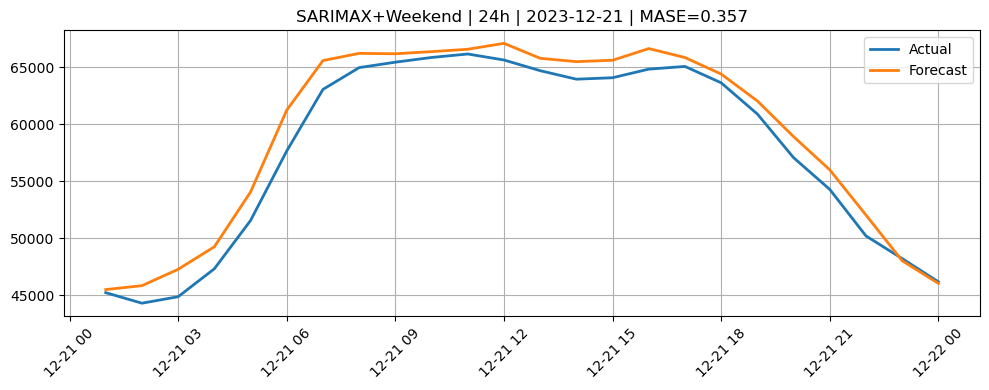


▶️  SARIMAX+Weekend | 7d | Anchor: 2023-12-21 | MASE=1.933
Training points: 12908, Testing points: 168
MAE  = 7545.60  CI: [6620.97, 8495.25]
RMSE = 9752.87  CI: [8712.15, 10722.74]
MASE = 1.933  CI: [1.696, 2.176]



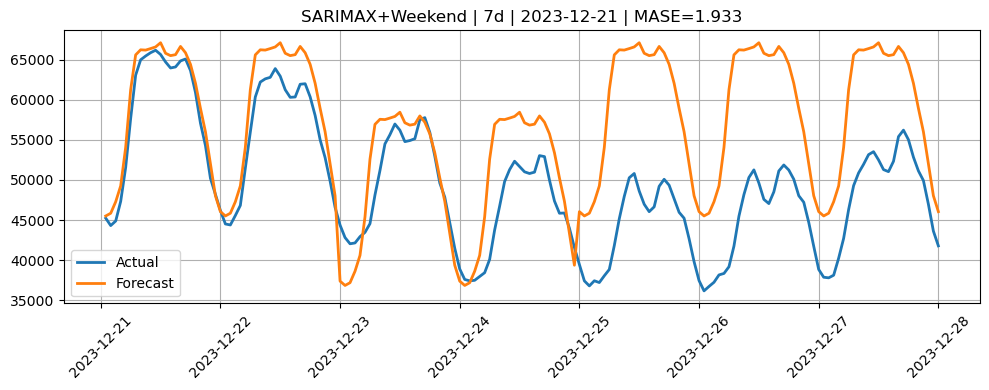


✅ Saved combined summary to sarimax_weekend_summary_all_anchors.csv
    Anchor Horizon         MAE    MAE_CI_L    MAE_CI_U        RMSE   RMSE_CI_L    RMSE_CI_U     MASE  MASE_CI_L  MASE_CI_U  Runtime (s)
2023-03-21     24h  604.581082  445.709453  762.705469  719.477480  560.034516   866.677866 0.157589   0.116178   0.198806     2.308372
2023-03-21      7d 1837.870743 1541.089786 2126.865324 2662.513046 2232.515852  3051.710682 0.479057   0.401698   0.554386     2.304808
2023-06-21     24h  755.366257  513.872168 1060.128620 1027.326478  620.586049  1456.032363 0.193592   0.131699   0.271699     3.096226
2023-06-21      7d 2306.763565 1936.117342 2726.092926 3458.533052 2904.377835  4055.657035 0.591197   0.496204   0.698666     3.114034
2023-12-21     24h 1394.866973 1086.895960 1732.703197 1625.203749 1288.073744  1973.132334 0.357332   0.278437   0.443878    10.212838
2023-12-21      7d 7545.600718 6620.969919 8495.254738 9752.869567 8712.152045 10722.741489 1.933004   1.696136   2

In [3]:
##SARIMAX LOAD + WEEKEND

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

# ─── Constants ───────────────────────────────────────────────────────────────
LOAD_PATH    = "updated_load_data_with_german_holidays.csv"
WEATHER_PATH = "Germany_average_temperature_humidity_2022_2024.csv"
HORIZONS     = {"24h": 24, "7d": 168}
ANCHORS      = [
    pd.Timestamp("2023-03-21 00:00:00"),
    pd.Timestamp("2023-06-21 00:00:00"),
    pd.Timestamp("2023-12-21 00:00:00"),
]

# ─── 1. Load & preprocess ────────────────────────────────────────────────────
def load_data():
    # No global interpolation—missing y's remain for SARIMAX to handle
    ld = (
        pd.read_csv(LOAD_PATH, parse_dates=["Time"])
          .assign(Time=lambda d: d["Time"].dt.tz_localize(None))
          .set_index("Time").asfreq("H")
          .rename(columns={"Actual Load": "y"})[["y"]]
    )
    w = (
        pd.read_csv(WEATHER_PATH, parse_dates=["DateTime"])
          .assign(DateTime=lambda d: d["DateTime"].dt.tz_localize(None))
          .set_index("DateTime").asfreq("H")
          .rename(columns={"AverageTemperature":"temp_fc","AverageHumidity":"hum_fc"})
    )
    return ld.reset_index().rename(columns={"Time":"ds"}), w

# ─── 2. Forecast weather & add noise ────────────────────────────────────────
def add_realistic_weather_forecast_errors(fc_t, fc_h, h):
    base_t, base_h = 0.8, 3.0; growth, ar = 0.15, 0.85
    te = np.zeros(h); he = np.zeros(h)
    for i in range(h):
        st = base_t*(1+growth*(i/24)); sh = base_h*(1+growth*(i/24))
        if i==0:
            te[i] = np.random.normal(0,st); he[i] = np.random.normal(0,sh)
        else:
            te[i] = ar*te[i-1] + np.random.normal(0, st*np.sqrt(1-ar**2))
            he[i] = ar*he[i-1] + np.random.normal(0, sh*np.sqrt(1-ar**2))
    hours = np.arange(h)%24
    diurnal = 0.4*np.sin(2*np.pi*(hours-10)/24)
    return fc_t+te+diurnal, fc_h+he

def forecast_weather(w, anchor, h):
    order,seas = (1,0,1),(1,0,1,24)
    wt = w[w.index<=anchor]
    m_t = SARIMAX(wt["temp_fc"], order=order, seasonal_order=seas,
                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    m_h = SARIMAX(wt["hum_fc"], order=order, seasonal_order=seas,
                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    idx = pd.date_range(anchor+pd.Timedelta(hours=1),periods=h,freq="H")
    t_fc = m_t.get_forecast(h).predicted_mean.values
    h_fc = m_h.get_forecast(h).predicted_mean.values
    t_no, h_no = add_realistic_weather_forecast_errors(t_fc,h_fc,h)
    df = pd.DataFrame({"temp_fc":t_no,"hum_fc":h_no}, index=idx)
    df.index.name="ds"
    return df

# ─── 3. Feature engineering ─────────────────────────────────────────────────
def engineer_features(w_train, w_fc):
    df = w_train.copy()
    df["temp_diff_3h"]   = df["temp_fc"] - df["temp_fc"].shift(3)
    df["temp_roll_6h"]   = df["temp_fc"].rolling(6).mean()
    df["hum_roll_6h"]    = df["hum_fc"].rolling(6).mean()
    df["temp_x_hum"]     = df["temp_fc"]*df["hum_fc"]
    df["heating_demand"] = np.clip(18-df["temp_fc"],0,None)
    df["cooling_demand"] = np.clip(df["temp_fc"]-18,0,None)
    df["is_weekend"]     = df.index.dayofweek.isin([5,6]).astype(int)
    feats_train = df.dropna()

    hist = w_train.rename_axis("ds")
    td,tr,hr = [],[],[]
    for i,(_,row) in enumerate(w_fc.iterrows()):
        prev = hist["temp_fc"].iloc[-(3-i)] if i<3 else w_fc["temp_fc"].iloc[i-3]
        td.append(row["temp_fc"]-prev)
        seq_t = list(hist["temp_fc"].iloc[-5:]) + list(w_fc["temp_fc"].iloc[:i+1])
        seq_h = list(hist["hum_fc"].iloc[-5:])  + list(w_fc["hum_fc"].iloc[:i+1])
        tr.append(np.mean(seq_t[-6:])); hr.append(np.mean(seq_h[-6:]))
    feats_test = w_fc.assign(
        temp_diff_3h=td, temp_roll_6h=tr, hum_roll_6h=hr,
        temp_x_hum=w_fc["temp_fc"]*w_fc["hum_fc"],
        heating_demand=np.clip(18-w_fc["temp_fc"],0,None),
        cooling_demand=np.clip(w_fc["temp_fc"]-18,0,None),
        is_weekend=w_fc.index.dayofweek.isin([5,6]).astype(int)
    )
    return feats_train, feats_test

def merge_and_slice(ld, feats_tr, feats_te, anchor, h):
    # no cross-boundary interpolation here
    feats_tr.index.name = feats_te.index.name = "ds"
    all_feats = pd.concat([feats_tr, feats_te]).reset_index()
    train_ld = ld[ld["ds"]<=anchor]
    test_ld  = ld[(ld["ds"]>anchor)&(ld["ds"]<=anchor+pd.Timedelta(hours=h))]
    df_all = pd.merge(pd.concat([train_ld, test_ld]), all_feats, on="ds", how="inner")
    train = df_all[df_all["ds"]<=anchor]
    test  = df_all[(df_all["ds"]>anchor)&(df_all["ds"]<=anchor+pd.Timedelta(hours=h))]
    return train, test

# ─── 4. Error metrics (MASE) ─────────────────────────────────────────────────
def mase(y_true, y_pred, y_train, m=24):
    num = np.mean(np.abs(y_true - y_pred))
    den = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    return num / den

def evaluate(y_true, y_pred, y_train):
    mae     = mean_absolute_error(y_true, y_pred)
    rmse    = np.sqrt(mean_squared_error(y_true, y_pred))
    mase_val = mase(y_true, y_pred, y_train.values, m=24)
    return mae, rmse, mase_val

def bootstrap_metrics(y_true, y_pred, y_train, n_boot=1000, ci=95):
    rng = np.random.default_rng(42)
    mae_list, rmse_list, mase_list = [], [], []
    for _ in range(n_boot):
        idx = rng.choice(len(y_true), size=len(y_true), replace=True)
        yt, yp = y_true[idx], y_pred[idx]
        mae_list.append(mean_absolute_error(yt, yp))
        rmse_list.append(np.sqrt(mean_squared_error(yt, yp)))
        mase_list.append(mase(yt, yp, y_train.values, m=24))
    lo, hi = (100-ci)/2, 100-(100-ci)/2
    return {
        "MAE_CI":  (np.percentile(mae_list, lo), np.percentile(mae_list, hi)),
        "RMSE_CI": (np.percentile(rmse_list, lo), np.percentile(rmse_list, hi)),
        "MASE_CI": (np.percentile(mase_list, lo), np.percentile(mase_list, hi)),
    }

# ─── 5. Main loop ────────────────────────────────────────────────────────────
def main():
    ld, w = load_data()
    all_results = []

    for anchor in ANCHORS:
        for label, h in HORIZONS.items():
            # 1) forecast weather + engineer features + merge
            w_fc       = forecast_weather(w, anchor, h)
            feats_tr, feats_te = engineer_features(w[w.index<=anchor], w_fc)
            train_df, test_df  = merge_and_slice(ld, feats_tr, feats_te, anchor, h)
            train_df = train_df.set_index("ds")
            # interpolate the two (or fewer) missing y’s in-sample only, then back to a column
            train_df["y"] = train_df["y"].interpolate(method="time").fillna(method="bfill")
            train_df = train_df.reset_index()

            # 2) fill exogs separately by median
            exogs = ["is_weekend"]
            for c in exogs:
                med = train_df[c].median()
                train_df[c].fillna(med, inplace=True)
                test_df[c].fillna(med, inplace=True)

            # 3) fit & forecast
            start = time.time()
            mod = SARIMAX(
                train_df["y"], exog=train_df[exogs],
                order=(1,0,1), seasonal_order=(0,1,0,24),
                enforce_stationarity=False,enforce_invertibility=False
            ).fit(disp=False, maxiter=200)
            fc = mod.get_forecast(steps=len(test_df), exog=test_df[exogs]).predicted_mean
            runtime = time.time()-start

            # 4) eval + CI using MASE
            mask   = ~test_df["y"].isna()
            y_true = test_df.loc[mask, "y"].values
            y_pred = fc.loc[test_df.index[mask]].values

            mae, rmse, mase_val = evaluate(y_true, y_pred, train_df["y"])
            ci = bootstrap_metrics(y_true, y_pred, train_df["y"])
            
            print(f"\n▶️  SARIMAX+Weekend | {label} | Anchor: {anchor.date()} | "
                f"MASE={mase_val:.3f}")
            print(f"Training points: {len(train_df)}, Testing points: {len(test_df)}")
            print(f"MAE  = {mae:.2f}  CI: [{ci['MAE_CI'][0]:.2f}, {ci['MAE_CI'][1]:.2f}]")
            print(f"RMSE = {rmse:.2f}  CI: [{ci['RMSE_CI'][0]:.2f}, {ci['RMSE_CI'][1]:.2f}]")
            print(f"MASE = {mase_val:.3f}  CI: [{ci['MASE_CI'][0]:.3f}, {ci['MASE_CI'][1]:.3f}]\n")

            all_results.append({
                "Anchor":    anchor.date(),
                "Horizon":   label,
                "MAE":       mae,
                "MAE_CI_L":  ci["MAE_CI"][0],"MAE_CI_U": ci["MAE_CI"][1],
                "RMSE":      rmse,
                "RMSE_CI_L": ci["RMSE_CI"][0],"RMSE_CI_U":ci["RMSE_CI"][1],
                "MASE":      mase_val,
                "MASE_CI_L": ci["MASE_CI"][0],"MASE_CI_U":ci["MASE_CI"][1],
                "Runtime (s)": runtime
            })

            # 5) output & plot with MASE title
            out_df = pd.DataFrame({
                "timestamp": test_df.loc[mask, "ds"],
                "actual":    y_true,
                "forecast":  y_pred
            })
            out_df.to_csv(f"sarimax_weekend_forecast_{label}_{anchor.date()}.csv", index=False)

            plt.figure(figsize=(10,4))
            plt.plot(out_df["timestamp"], out_df["actual"], label="Actual", lw=2)
            plt.plot(out_df["timestamp"], out_df["forecast"], label="Forecast", lw=2)
            plt.title(f"SARIMAX+Weekend | {label} | {anchor.date()} | MASE={mase_val:.3f}")
            plt.xticks(rotation=45); plt.grid(True); plt.legend(); plt.tight_layout()
            plt.savefig(f"sarimax_weekend_plot_{label}_{anchor.date()}.png")
            plt.show()

    summary = pd.DataFrame(all_results)
    summary.to_csv("sarimax_weekend_summary_all_anchors.csv", index=False)
    # force pandas to dump the entire DataFrame
    print("\n✅ Saved combined summary to sarimax_weekend_summary_all_anchors.csv")
    print(summary.to_string(index=False))


if __name__ == "__main__":
    main()


  Using cached nixtla-0.6.6-py3-none-any.whl.metadata (15 kB)
  Using cached orjson-3.10.18-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (41 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached utilsforecast-0.2.12-py3-none-any.whl.metadata (7.6 kB)
Using cached nixtla-0.6.6-py3-none-any.whl (33 kB)
Using cached utilsforecast-0.2.12-py3-none-any.whl (42 kB)
Using cached orjson-3.10.18-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (133 kB)
Using cached tenacity-9.1.2-py3-none-any.whl (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [nixtla]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...



▶️  24h | Anchor: 2023-03-21 → train=720, test=24


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved CSV: timegpt_loadonly_24h_2023-03-21.csv


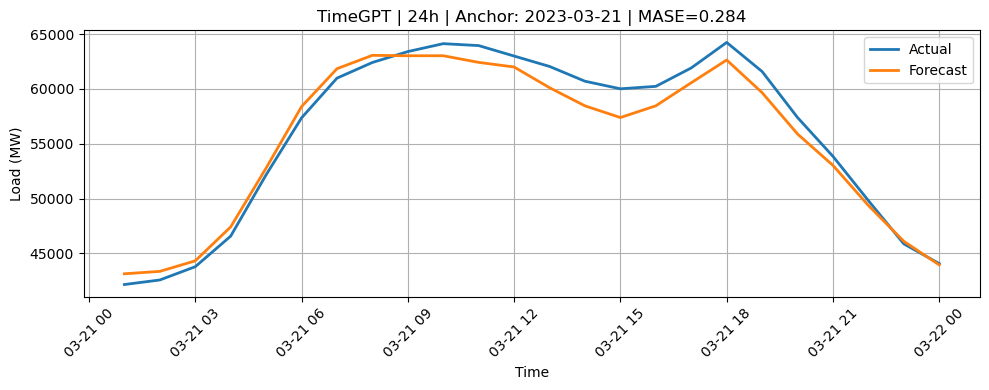

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...



▶️  7d | Anchor: 2023-03-21 → train=1440, test=168


INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved CSV: timegpt_loadonly_7d_2023-03-21.csv


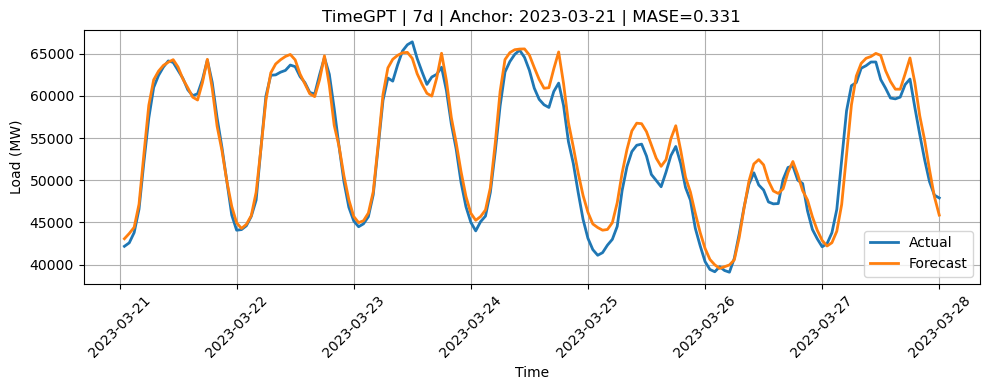

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



▶️  24h | Anchor: 2023-06-21 → train=720, test=24
  • Saved CSV: timegpt_loadonly_24h_2023-06-21.csv


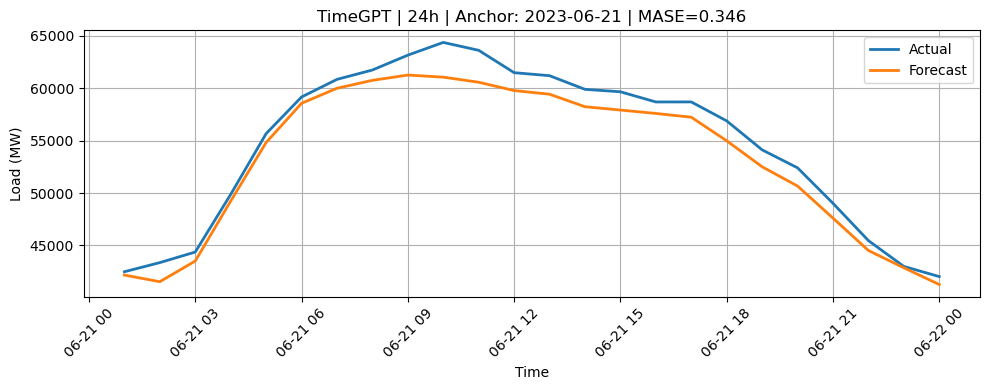

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



▶️  7d | Anchor: 2023-06-21 → train=1440, test=168
  • Saved CSV: timegpt_loadonly_7d_2023-06-21.csv


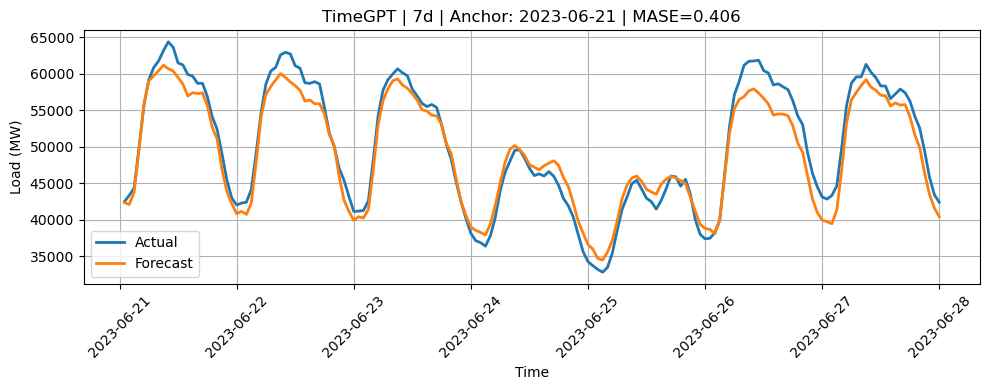

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



▶️  24h | Anchor: 2023-12-21 → train=720, test=24
  • Saved CSV: timegpt_loadonly_24h_2023-12-21.csv


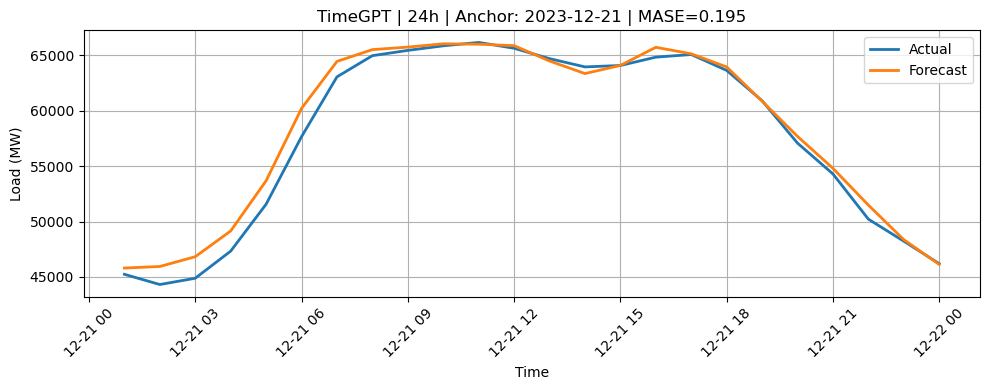

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...



▶️  7d | Anchor: 2023-12-21 → train=1440, test=168
  • Saved CSV: timegpt_loadonly_7d_2023-12-21.csv


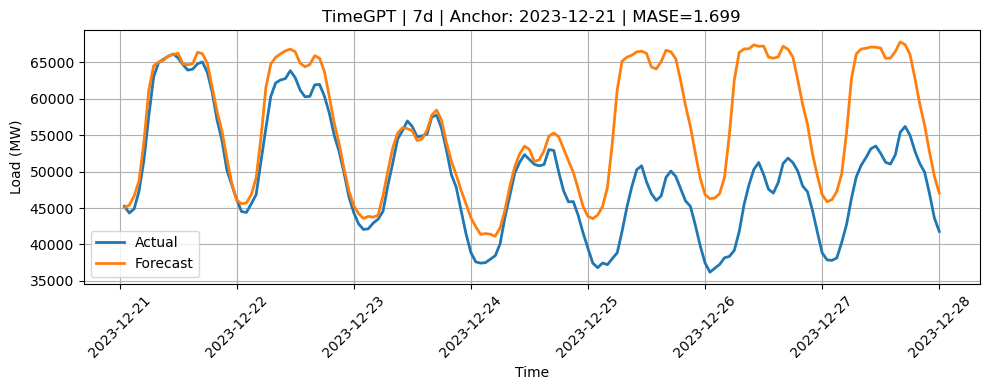


✅ Saved combined summary to timegpt_loadonly_summary_all_anchors.csv
       Anchor Horizon          MAE     MAE_CI_L     MAE_CI_U         RMSE  \
0  2023-03-21     24h  1120.079958   883.431199  1389.365626  1290.761040   
1  2023-03-21      7d  1311.582054  1162.946872  1466.257467  1641.153219   
2  2023-06-21     24h  1380.005375  1091.600198  1706.247910  1569.512040   
3  2023-06-21      7d  1755.710958  1584.827376  1910.550700  2064.506197   
4  2023-12-21     24h   756.223625   464.456439  1070.421935  1061.240623   
5  2023-12-21      7d  6970.179190  6002.016431  8025.513451  9596.876881   

     RMSE_CI_L     RMSE_CI_U      MASE  MASE_CI_L  MASE_CI_U  Runtime (s)  
0  1031.841829   1555.816115  0.283753   0.223802   0.351972     1.342562  
1  1456.593291   1821.440652  0.331345   0.293795   0.370421     1.129629  
2  1239.781787   1918.934904  0.345907   0.273617   0.427682     0.556933  
3  1886.669117   2228.027965  0.406009   0.366492   0.441816     0.589943  
4   689.25

In [4]:
!pip install nixtla
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from nixtla import NixtlaClient
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

# ─── Constants ───────────────────────────────────────────────────────────────
LOAD_PATH  = "updated_load_data_with_german_holidays.csv"
API_KEY    = "nixak-ZcLhUxDDPKBLBM4uvP3Q3cC8jbCHYxTZkBkbWYcZ6DJgqZL8wACA9R3VuWXfChpkbLNK8Ccw4Q4KUBKF"
HORIZONS   = {"24h": 24, "7d": 168}
TRAIN_DAYS = {"24h": 30, "7d": 60}
ANCHORS    = [
    pd.Timestamp("2023-03-21 00:00:00"),
    pd.Timestamp("2023-06-21 00:00:00"),
    pd.Timestamp("2023-12-21 00:00:00"),
]

# ─── 1. Initialize client & utilities ───────────────────────────────────────
nixtla_client = NixtlaClient(api_key=API_KEY)

def mase(y_true, y_pred, y_train, m=24):
    num = np.mean(np.abs(y_true - y_pred))
    den = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    return num/den

def evaluate(y_true, y_pred, y_train):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse, mase(y_true, y_pred, y_train.values, m=24)

def bootstrap_metrics(y_true, y_pred, y_train, n_boot=1000, ci=95):
    rng = np.random.default_rng(42)
    mae_l, rmse_l, mase_l = [], [], []
    for _ in range(n_boot):
        idx = rng.choice(len(y_true), len(y_true), True)
        yt, yp = y_true[idx], y_pred[idx]
        mae_l.append(mean_absolute_error(yt, yp))
        rmse_l.append(np.sqrt(mean_squared_error(yt, yp)))
        mase_l.append(mase(yt, yp, y_train.values, m=24))
    lo, hi = (100-ci)/2, 100-(100-ci)/2
    return {
      "MAE_CI":  (np.percentile(mae_l, lo),  np.percentile(mae_l, hi)),
      "RMSE_CI": (np.percentile(rmse_l, lo), np.percentile(rmse_l, hi)),
      "MASE_CI": (np.percentile(mase_l,lo),  np.percentile(mase_l,hi)),
    }


def load_data():
    df = (
        pd.read_csv(LOAD_PATH, parse_dates=["Time"])
          .assign(Time=lambda d: d["Time"].dt.tz_localize(None))
          .set_index("Time")
          .asfreq("H")
    )
    df = df.rename(columns={"Actual Load": "y"})[["y"]]
    return df.reset_index().rename(columns={"Time":"ds"})

def forecast_load_only(train_df, h):
    start = time.time()
    fc = nixtla_client.forecast(
        df=train_df,
        h=h,
        time_col="ds",
        target_col="y",
        freq="H",
        level=None,
        finetune_steps=0,
        model="timegpt-1-long-horizon" if h>24 else "timegpt-1",
        date_features=False,
        date_features_to_one_hot=False,
        hist_exog_list=None,
        X_df=None,
    )
    return fc, time.time()-start


# ─── 2. Main loop ────────────────────────────────────────────────────────────
def main():
    data = load_data()
    all_results = []

    for anchor in ANCHORS:
        for label, h in HORIZONS.items():
            window    = TRAIN_DAYS[label]
            train_start = anchor - timedelta(days=window)

            train_df = data[(data["ds"]>train_start)&(data["ds"]<=anchor)].copy()
            train_df = train_df.set_index("ds")
            train_df["y"] = train_df["y"].interpolate(method="time").fillna(method="bfill")
            train_df = train_df.reset_index()
            test_df  = data[(data["ds"]>anchor)&(data["ds"]<=anchor+timedelta(hours=h))].copy()
            test_h   = len(test_df)

            print(f"\n▶️  {label} | Anchor: {anchor.date()} → train={len(train_df)}, test={test_h}")

            # forecast
            fc, runtime = forecast_load_only(train_df, test_h)
            y_true = test_df["y"].values
            y_pred = fc["TimeGPT"].values[:test_h]

            # metrics + CI
            mae, rmse, mase_val = evaluate(y_true, y_pred, train_df["y"])
            ci = bootstrap_metrics(y_true, y_pred, train_df["y"])

            # save summary row
            all_results.append({
                "Anchor": anchor.date(),
                "Horizon": label,
                "MAE":      mae,
                "MAE_CI_L": ci["MAE_CI"][0],
                "MAE_CI_U": ci["MAE_CI"][1],
                "RMSE":     rmse,
                "RMSE_CI_L":ci["RMSE_CI"][0],
                "RMSE_CI_U":ci["RMSE_CI"][1],
                "MASE":        mase_val,
                "MASE_CI_L":   ci["MASE_CI"][0],
                "MASE_CI_U":   ci["MASE_CI"][1],
                "Runtime (s)": runtime
            })

            # per-run CSV
            export_df = pd.DataFrame({
                "timestamp":test_df["ds"].values,
                "actual":   y_true,
                "forecast": y_pred
            })
            csv_path = f"timegpt_loadonly_{label}_{anchor.date()}.csv"
            export_df.to_csv(csv_path, index=False)
            print(f"  • Saved CSV: {csv_path}")

            # per-run plot
            plt.figure(figsize=(10,4))
            plt.plot(test_df["ds"], y_true, label="Actual", lw=2)
            plt.plot(test_df["ds"], y_pred, label="Forecast", lw=2)
            lo = [c for c in fc.columns if "lo_80" in c]
            hi = [c for c in fc.columns if "hi_80" in c]
            if lo and hi:
                plt.fill_between(fc["ds"], fc[lo[0]], fc[hi[0]], alpha=0.2)
            plt.title(f"TimeGPT | {label} | Anchor: {anchor.date()} | MASE={mase_val:.3f}")
            plt.xlabel("Time"); plt.ylabel("Load (MW)")
            plt.legend(); plt.grid(); plt.xticks(rotation=45); plt.tight_layout()

            plot_path = f"timegpt_loadonly_{label}_{anchor.date()}.png"
            plt.savefig(plot_path)
            plt.show()

    # combined summary
    summary_df = pd.DataFrame(all_results)
    summary_df.to_csv("timegpt_loadonly_summary_all_anchors.csv", index=False)
    print("\n✅ Saved combined summary to timegpt_loadonly_summary_all_anchors.csv")
    print(summary_df)

if __name__=="__main__":
    main()


Missing values in load data: 2
Missing values in temperature: 0
Missing values in humidity: 0


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using future exogenous features: ['hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend', 'is_holiday', 'temp_fc', 'hum_fc', 'temp_diff_3h', 'temp_roll_6h', 'hum_roll_6h', 'temp_x_hum', 'heating_demand', 'cooling_demand']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+exog_24h_2023-03-21.csv


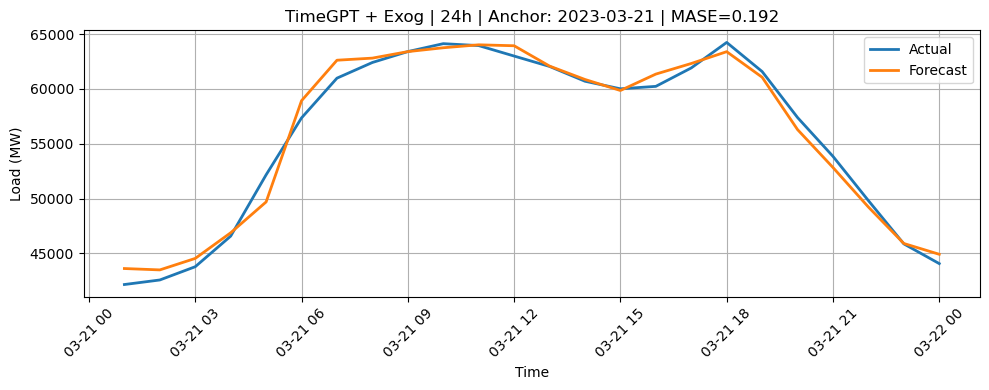

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using future exogenous features: ['hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend', 'is_holiday', 'temp_fc', 'hum_fc', 'temp_diff_3h', 'temp_roll_6h', 'hum_roll_6h', 'temp_x_hum', 'heating_demand', 'cooling_demand']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+exog_7d_2023-03-21.csv


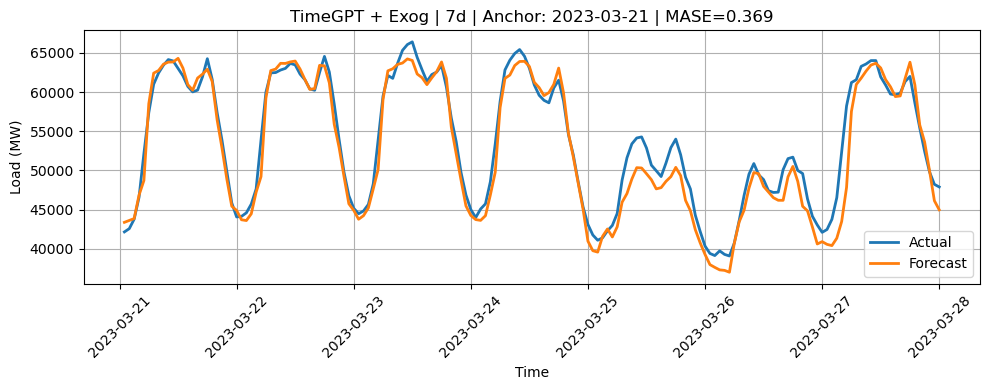

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend', 'is_holiday', 'temp_fc', 'hum_fc', 'temp_diff_3h', 'temp_roll_6h', 'hum_roll_6h', 'temp_x_hum', 'heating_demand', 'cooling_demand']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+exog_24h_2023-06-21.csv


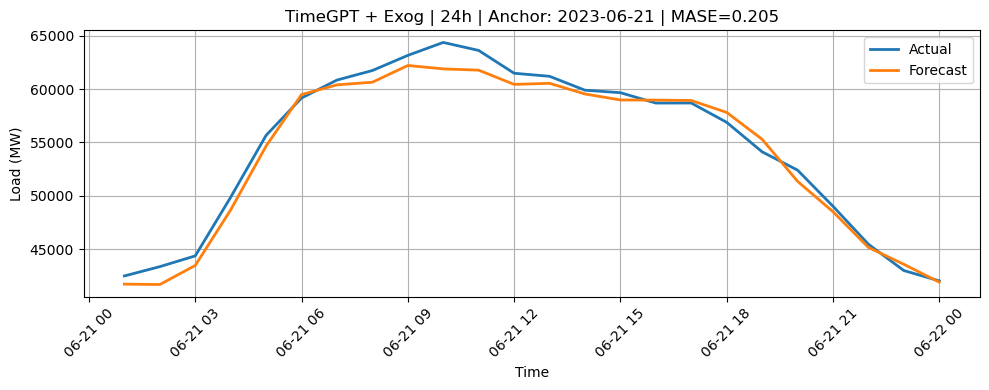

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend', 'is_holiday', 'temp_fc', 'hum_fc', 'temp_diff_3h', 'temp_roll_6h', 'hum_roll_6h', 'temp_x_hum', 'heating_demand', 'cooling_demand']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+exog_7d_2023-06-21.csv


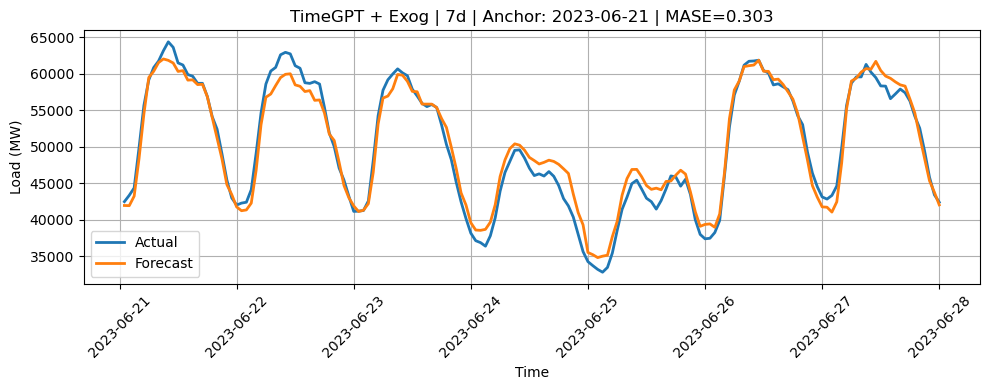

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend', 'is_holiday', 'temp_fc', 'hum_fc', 'temp_diff_3h', 'temp_roll_6h', 'hum_roll_6h', 'temp_x_hum', 'heating_demand', 'cooling_demand']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+exog_24h_2023-12-21.csv


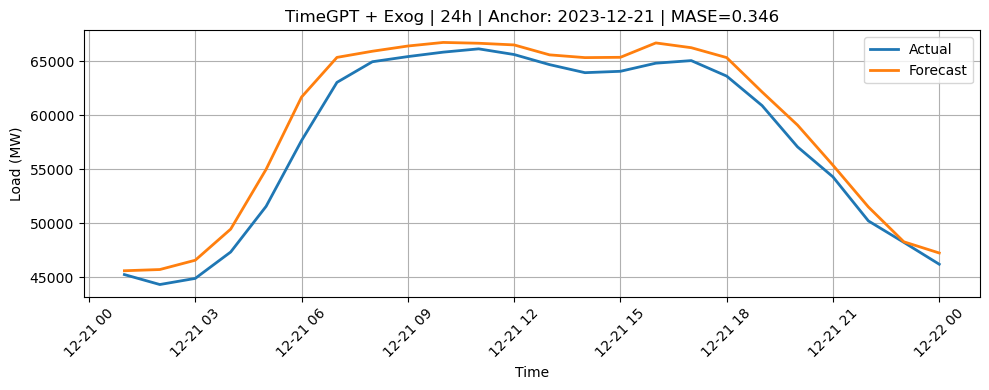

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['hour', 'day_of_week', 'month', 'day_of_year', 'is_weekend', 'is_holiday', 'temp_fc', 'hum_fc', 'temp_diff_3h', 'temp_roll_6h', 'hum_roll_6h', 'temp_x_hum', 'heating_demand', 'cooling_demand']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+exog_7d_2023-12-21.csv


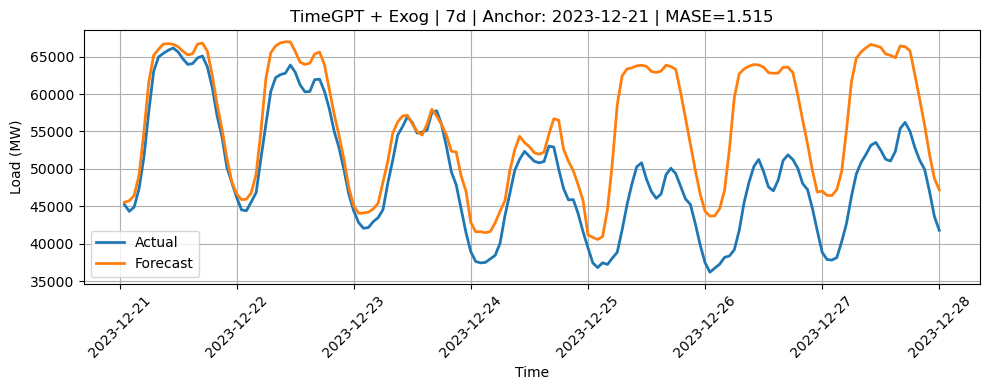

Saved combined summary to timegpt_load+exog_summary_all_anchors.csv

    Anchor Horizon         MAE    MAE_CI_L    MAE_CI_U        RMSE   RMSE_CI_L   RMSE_CI_U     MASE  MASE_CI_L  MASE_CI_U  Runtime (s)
2023-03-21     24h  738.403417  502.907136  973.826984  953.617491  670.467992 1221.877405 0.191514   0.130435   0.252574    77.369116
2023-03-21      7d 1423.049315 1226.733679 1662.623427 2017.265239 1636.305330 2444.136853 0.369085   0.318168   0.431222    77.364740
2023-06-21     24h  857.922333  658.206540 1096.440104 1018.175622  767.346459 1293.508258 0.204697   0.157046   0.261607    95.817612
2023-06-21      7d 1270.663542 1132.237013 1421.935242 1556.207883 1406.088886 1712.102821 0.303176   0.270148   0.339268    93.741398
2023-12-21     24h 1446.362125 1133.587986 1810.810616 1688.997587 1277.920013 2127.956324 0.346084   0.271244   0.433289   125.145190
2023-12-21      7d 6330.726804 5503.488713 7177.958294 8375.568046 7421.649297 9276.543765 1.514810   1.316869   1.717534

In [5]:
!pip install nixtla
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from nixtla import NixtlaClient
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

# ─── Constants ───────────────────────────────────────────────────────────────
LOAD_PATH    = "updated_load_data_with_german_holidays.csv"
WEATHER_PATH = "Germany_average_temperature_humidity_2022_2024.csv"
API_KEY      = "nixak-ZcLhUxDDPKBLBM4uvP3Q3cC8jbCHYxTZkBkbWYcZ6DJgqZL8wACA9R3VuWXfChpkbLNK8Ccw4Q4KUBKF"
ANCHORS = [
    pd.Timestamp("2023-03-21 00:00:00"),
    pd.Timestamp("2023-06-21 00:00:00"),
    pd.Timestamp("2023-12-21 00:00:00"),
]

HORIZONS     = {"24h": 24, "7d": 168}

# ─── 1. Initialize TimeGPT client ───────────────────────────────────────────
nixtla_client = NixtlaClient(api_key=API_KEY)

def mase(y_true, y_pred, y_train, m=24):
    """
    Calculates the Mean Absolute Scaled Error (MASE).
    m: The seasonal period (24 for hourly data with daily seasonality).
    """
    # Calculate the forecast error
    forecast_error = np.mean(np.abs(y_true - y_pred))
    
    # Calculate the naive forecast error (persistence in seasonal data)
    naive_error = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    
    return forecast_error / naive_error


# ─── 2. Load & preprocess raw data ──────────────────────────────────────────
def load_data():
    ld = (
        pd.read_csv(LOAD_PATH, parse_dates=["Time"])
        .assign(Time=lambda df: df["Time"].dt.tz_localize(None))
        .set_index("Time")
        .rename(columns={"Actual Load": "y"})
        .sort_index()
        .asfreq("H")
    )
    w = (
        pd.read_csv(WEATHER_PATH, parse_dates=["DateTime"])
        .assign(DateTime=lambda df: df["DateTime"].dt.tz_localize(None))
        .set_index("DateTime")
        .sort_index()
        .asfreq("H")
    )
    return ld, w

# ─── 3a. Add realistic error model for forecasted weather ───────────────────
def add_realistic_weather_forecast_errors(fc_t, fc_h, horizon):
    base_temp_error = 0.8
    base_hum_error = 3.0
    growth_rate = 0.15
    ar_coeff = 0.85

    temp_errors = np.zeros(horizon)
    hum_errors = np.zeros(horizon)

    for h in range(horizon):
        day = h / 24
        temp_scale = base_temp_error * (1 + growth_rate * day)
        hum_scale = base_hum_error * (1 + growth_rate * day)

        if h == 0:
            temp_errors[h] = np.random.normal(0, temp_scale)
            hum_errors[h] = np.random.normal(0, hum_scale)
        else:
            temp_errors[h] = ar_coeff * temp_errors[h-1] + np.random.normal(0, temp_scale * np.sqrt(1 - ar_coeff**2))
            hum_errors[h] = ar_coeff * hum_errors[h-1] + np.random.normal(0, hum_scale * np.sqrt(1 - ar_coeff**2))

    hours = np.arange(horizon) % 24
    diurnal_temp = 0.4 * np.sin(2 * np.pi * (hours - 10) / 24)

    fc_t_with_errors = fc_t + temp_errors + diurnal_temp
    fc_h_with_errors = fc_h + hum_errors

    return fc_t_with_errors, fc_h_with_errors

# ─── 3b. Forecast weather via SARIMAX and add noise ─────────────────────────
def forecast_weather(w, horizon, anchor):
    order, seas = (1, 0, 1), (1, 0, 1, 24)
    w_train = w[w.index <= anchor]
    m_t = SARIMAX(w_train["AverageTemperature"], order=order, seasonal_order=seas).fit(disp=False)
    m_h = SARIMAX(w_train["AverageHumidity"],    order=order, seasonal_order=seas).fit(disp=False)

    idx = pd.date_range(anchor + pd.Timedelta(hours=1), periods=horizon, freq="H")
    fc_t = m_t.get_forecast(horizon).predicted_mean.values
    fc_h = m_h.get_forecast(horizon).predicted_mean.values

    fc_t_noisy, fc_h_noisy = add_realistic_weather_forecast_errors(fc_t, fc_h, horizon)

    return pd.DataFrame({
        "temp_fc": fc_t_noisy,
        "hum_fc": fc_h_noisy
    }, index=idx)

# ─── 4. Engineer weather features ────────────────────────────────────────────
def engineer_features_train(w, anchor):
    train_w = w[w.index <= anchor].copy()
    train_w = train_w.rename(columns={
        "AverageTemperature": "temp_fc",
        "AverageHumidity": "hum_fc"
    })
    train_feats = train_w.assign(
        temp_diff_3h   = train_w["temp_fc"] - train_w["temp_fc"].shift(3),
        temp_roll_6h   = train_w["temp_fc"].rolling(6).mean(),
        hum_roll_6h    = train_w["hum_fc"].rolling(6).mean(),
        temp_x_hum     = train_w["temp_fc"] * train_w["hum_fc"],
        heating_demand = np.clip(18 - train_w["temp_fc"], 0, None),
        cooling_demand = np.clip(train_w["temp_fc"] - 18, 0, None),
    ).dropna()
    return train_feats

def engineer_features_test(w, w_fc, anchor):
    test_feats = w_fc.copy()
    temp_diff_3h = []
    temp_roll_6h = []
    hum_roll_6h = []

    historical_temp = w[w.index <= anchor]["AverageTemperature"].rename("temp_fc").copy()
    historical_hum = w[w.index <= anchor]["AverageHumidity"].rename("hum_fc").copy()

    for i, (idx, row) in enumerate(w_fc.iterrows()):
        current_time = idx
        if i < 3:
            lookback_idx = current_time - pd.Timedelta(hours=3)
            past_temp = historical_temp.loc[lookback_idx] if lookback_idx <= anchor else w_fc.loc[lookback_idx, "temp_fc"]
            temp_diff_3h.append(row["temp_fc"] - past_temp)
        else:
            temp_diff_3h.append(row["temp_fc"] - w_fc.iloc[i-3]["temp_fc"])

        if i == 0:
            temp_window = list(historical_temp.iloc[-5:]) + [row["temp_fc"]]
            hum_window = list(historical_hum.iloc[-5:]) + [row["hum_fc"]]
        elif i < 5:
            hist_points_needed = 5 - i
            temp_window = list(historical_temp.iloc[-hist_points_needed:]) + list(w_fc.iloc[:i+1]["temp_fc"])
            hum_window = list(historical_hum.iloc[-hist_points_needed:]) + list(w_fc.iloc[:i+1]["hum_fc"])
        else:
            temp_window = list(w_fc.iloc[i-5:i+1]["temp_fc"])
            hum_window = list(w_fc.iloc[i-5:i+1]["hum_fc"])

        temp_roll_6h.append(np.mean(temp_window))
        hum_roll_6h.append(np.mean(hum_window))

    test_feats = test_feats.assign(
        temp_diff_3h=temp_diff_3h,
        temp_roll_6h=temp_roll_6h,
        hum_roll_6h=hum_roll_6h,
        temp_x_hum=test_feats["temp_fc"] * test_feats["hum_fc"],
        heating_demand=np.clip(18 - test_feats["temp_fc"], 0, None),
        cooling_demand=np.clip(test_feats["temp_fc"] - 18, 0, None)
    )
    return test_feats

# ─── 5. Merge load + features ────────────────────────────────────────────────
def build_dataset(ld, train_feats, test_feats, anchor):
    df_ld = (
        ld.rename_axis("ds")
          .reset_index()
          .assign(is_weekend=lambda df: df["ds"].dt.dayofweek.isin([5, 6]).astype(int))
    )
    train_feat_df = train_feats.rename_axis("ds").reset_index()
    test_feat_df = test_feats.rename_axis("ds").reset_index()

    # Create initial train and test sets
    train_df = pd.merge(df_ld[df_ld["ds"] <= anchor], train_feat_df, on="ds", how="inner")
    test_df = pd.merge(df_ld[df_ld["ds"] > anchor], test_feat_df, on="ds", how="inner")

    # --- FIX: Interpolate train_df and test_df separately ---
    train_df = (
        train_df.set_index("ds")
        .interpolate(method="time")
        .fillna(method="ffill")
        .reset_index()
    )
    test_df = (
        test_df.set_index("ds")
        .interpolate(method="time")
        .fillna(method="ffill")
        .reset_index()
    )
    # ---------------------------------------------------------

    # Combine the now-clean dataframes
    df = pd.concat([train_df, test_df], ignore_index=True)
    df = df.drop_duplicates(subset="ds").sort_values("ds").reset_index(drop=True)
    
    return df

# ─── 6. Train/test split ────────────────────────────────────────────────────
def get_train_test(df, horizon, anchor):
    train = df[df["ds"] <= anchor].copy()
    train = train[train["ds"] >= anchor - pd.Timedelta(days=90)]  # restrict training window
    test  = df[(df["ds"]  > anchor) & (df["ds"] <= anchor + pd.Timedelta(hours=horizon))].copy()
    return train, test

# ─── 7. Forecast load with TimeGPT ──────────────────────────────────────────
def forecast_load(train, test):
    h = len(test)
    feats = [c for c in train.columns if c not in {"ds", "y"}]

    if train["y"].isna().any():
        train["y"] = train["y"].fillna(method='ffill').fillna(method='bfill')

    for feat in feats:
        if train[feat].isna().any():
            train[feat] = train[feat].fillna(train[feat].median())
        if test[feat].isna().any():
            test[feat] = test[feat].fillna(train[feat].median())

    fc = nixtla_client.forecast(
        df   = train[["ds","y"] + feats],
        X_df = test[["ds"]     + feats],
        h    = h,
        time_col   = "ds",
        target_col = "y",
        freq       = "H",
        level      = None,
        finetune_steps = 0,
        model      = "timegpt-1-long-horizon" if h > 24 else "timegpt-1",
    )
    return fc

# ─── 8. Evaluate & plot ────────────────────────────────────────────────────
def evaluate(actual, pred, y_train):
    mae  = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mase_val = mase(actual, pred, y_train.values, m=24) # Pass y_train to mase
    return mae, rmse, mase_val

# Replace the old bootstrap_metrics() function with this one
def bootstrap_metrics(y_true, y_pred, y_train, n_boot=1000, ci=95):
    rng = np.random.default_rng(seed=42)
    mae_list, rmse_list, mase_list = [], [], [] # Swapped mape for mase

    for _ in range(n_boot):
        idx = rng.choice(len(y_true), size=len(y_true), replace=True)
        y_t = y_true[idx]
        y_p = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_t, y_p))
        rmse_list.append(np.sqrt(mean_squared_error(y_t, y_p)))
        mase_list.append(mase(y_t, y_p, y_train.values, m=24)) # Use mase here

    lower = (100 - ci) / 2
    upper = 100 - lower
    return {
        "MAE_CI": (np.percentile(mae_list, lower), np.percentile(mae_list, upper)),
        "RMSE_CI": (np.percentile(rmse_list, lower), np.percentile(rmse_list, upper)),
        "MASE_CI": (np.percentile(mase_list, lower), np.percentile(mase_list, upper)) # Return MASE_CI
    }


def plot_forecast(test, fc, title):
    plt.figure(figsize=(10,5))
    plt.plot(test["ds"], test["y"], label="Actual", lw=2)
    plt.plot(fc["ds"],   fc["TimeGPT"], label="Predicted", lw=2)
    lo = [c for c in fc.columns if "lo_80" in c]
    hi = [c for c in fc.columns if "hi_80" in c]
    if lo and hi:
        plt.fill_between(fc["ds"], fc[lo[0]], fc[hi[0]], alpha=0.2, label="80% CI")
    plt.title(title)
    plt.xlabel("Time"); plt.ylabel("Load (MW)")
    plt.legend(); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


# ─── 9. Main pipeline ───────────────────────────────────────────────────────
def main():
    ld, w = load_data()
    print(f"Missing values in load data: {ld['y'].isna().sum()}")
    print(f"Missing values in temperature: {w['AverageTemperature'].isna().sum()}")
    print(f"Missing values in humidity: {w['AverageHumidity'].isna().sum()}")

    # collect every anchor+horizon run here
    all_summaries = []

    for anchor in ANCHORS:
        for label, horizon in HORIZONS.items():
            start = time.perf_counter()

            # forecast weather + engineer features + build dataset + split
            w_fc       = forecast_weather(w, horizon, anchor)
            train_feats = engineer_features_train(w, anchor)
            test_feats  = engineer_features_test(w, w_fc, anchor)
            df_all      = build_dataset(ld, train_feats, test_feats, anchor)
            train, test = get_train_test(df_all, horizon, anchor)

            # forecast load, then evaluate
            fc     = forecast_load(train, test)
            y_true = test["y"].values
            y_pred = fc["TimeGPT"].values
            mae, rmse, mase_val = evaluate(y_true, y_pred, train["y"])
            ci = bootstrap_metrics(y_true, y_pred, train["y"])

            runtime = time.perf_counter() - start

            all_summaries.append({
                "Anchor":      anchor.date().isoformat(),
                "Horizon":     label,
                "MAE":         mae,
                "MAE_CI_L":    ci["MAE_CI"][0],
                "MAE_CI_U":    ci["MAE_CI"][1],
                "RMSE":        rmse,
                "RMSE_CI_L":   ci["RMSE_CI"][0],
                "RMSE_CI_U":   ci["RMSE_CI"][1],
                "MASE":        mase_val,
                "MASE_CI_L":   ci["MASE_CI"][0],
                "MASE_CI_U":   ci["MASE_CI"][1],
                "Runtime (s)": runtime
            })
            
            # per-run CSV
            export_df = pd.DataFrame({
                "timestamp": test["ds"].values,
                "actual":    y_true,
                "forecast":  y_pred
            })
            # Use a unique name for the exogenous results
            csv_path = f"timegpt_load+exog_{label}_{anchor.date()}.csv" 
            export_df.to_csv(csv_path, index=False)
            print(f"  • Saved per-run CSV: {csv_path}")

            # per-run plot
            plt.figure(figsize=(10, 4))
            plt.plot(test["ds"], y_true, label="Actual", lw=2)
            plt.plot(fc["ds"], y_pred, label="Forecast", lw=2)
            lo = [c for c in fc.columns if "lo_80" in c]
            hi = [c for c in fc.columns if "hi_80" in c]
            if lo and hi:
                plt.fill_between(fc["ds"], fc[lo[0]], fc[hi[0]], alpha=0.2, label="80% CI")
            
            plt.title(f"TimeGPT + Exog | {label} | Anchor: {anchor.date()} | MASE={mase_val:.3f}")
            plt.xlabel("Time")
            plt.ylabel("Load (MW)")
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()

            # Use a unique name for the exogenous plot
            plot_path = f"timegpt_load+exog_{label}_{anchor.date()}.png"
            plt.savefig(plot_path)
            plt.show()

    # after all anchors/horizons, save to CSV
    summary_df = pd.DataFrame(all_summaries)
    summary_df.to_csv("timegpt_load+exog_summary_all_anchors.csv", index=False)
    print("Saved combined summary to timegpt_load+exog_summary_all_anchors.csv\n")
    # now also show it
    print(summary_df.to_string(index=False))



if __name__ == "__main__":
    main()

Missing values in load data: 2
Missing values in temperature: 0
Missing values in humidity: 0


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using future exogenous features: ['is_weekend']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+weekend_24h_2023-03-21.csv


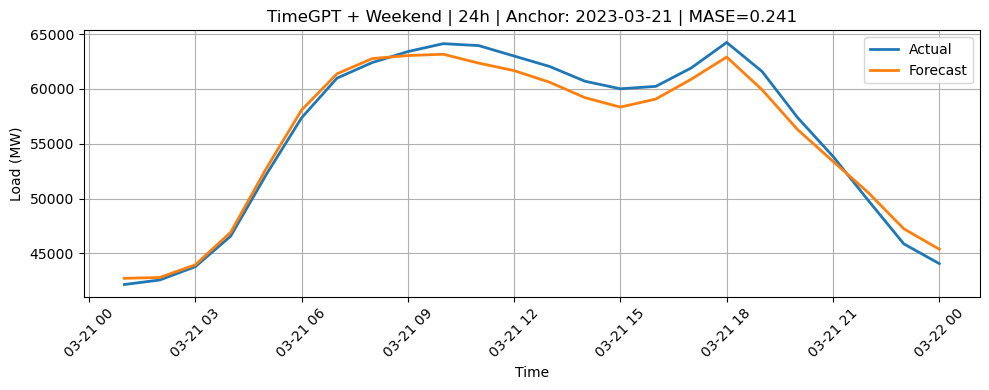

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Using future exogenous features: ['is_weekend']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+weekend_7d_2023-03-21.csv


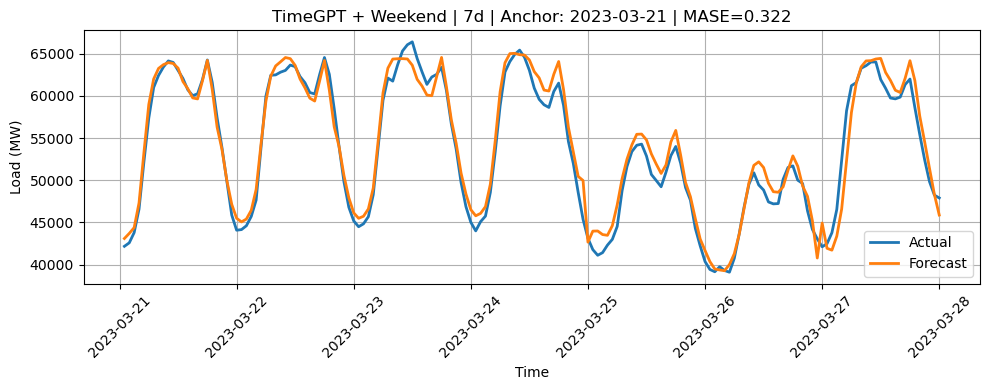

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['is_weekend']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+weekend_24h_2023-06-21.csv


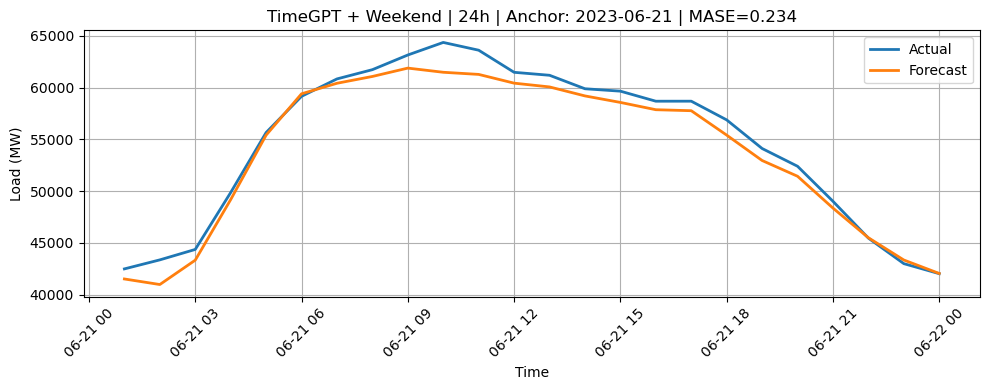

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['is_weekend']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+weekend_7d_2023-06-21.csv


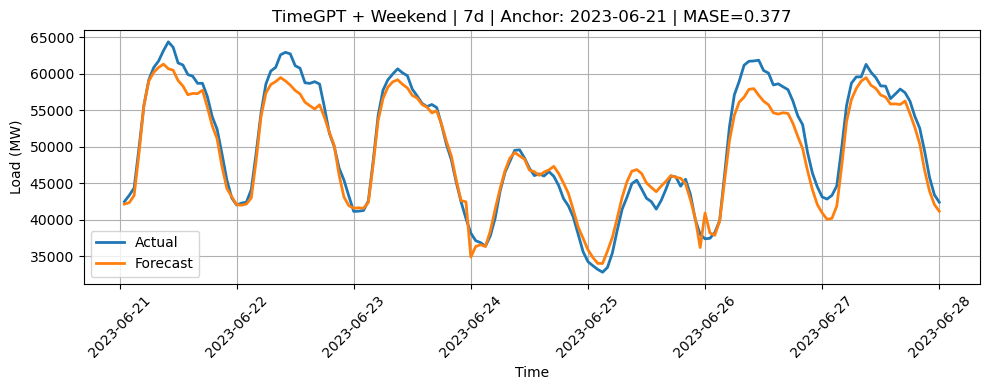

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['is_weekend']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+weekend_24h_2023-12-21.csv


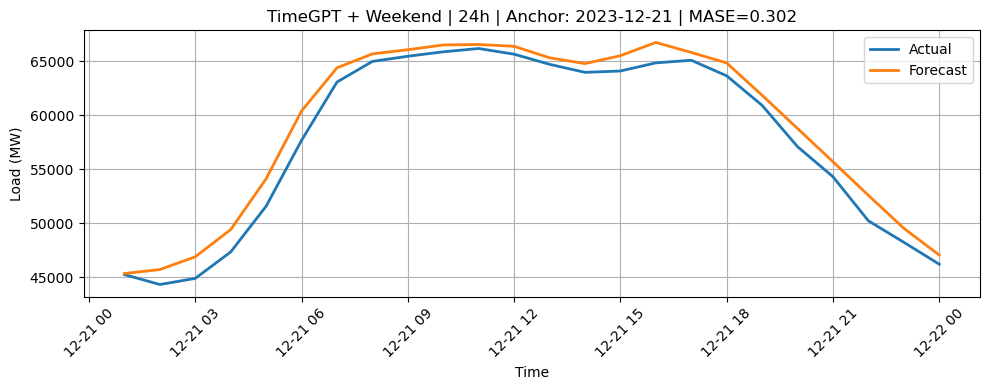

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['is_weekend']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


  • Saved per-run CSV: timegpt_load+weekend_7d_2023-12-21.csv


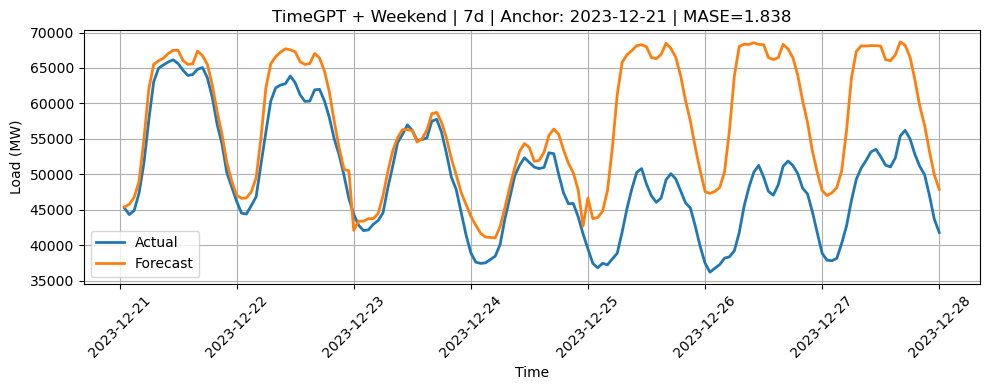

Saved combined summary to timegpt_load+weekend_summary_all_anchors.csv

    Anchor Horizon         MAE    MAE_CI_L    MAE_CI_U         RMSE   RMSE_CI_L    RMSE_CI_U     MASE  MASE_CI_L  MASE_CI_U  Runtime (s)
2023-03-21     24h  930.196375  740.311698 1142.203807  1052.343575  873.490666  1232.369643 0.241258   0.192009   0.296245    75.661151
2023-03-21      7d 1241.013327 1100.189285 1388.297191  1570.490263 1361.612521  1786.385942 0.321872   0.285348   0.360072    77.095555
2023-06-21     24h  978.980792  719.916376 1261.172856  1204.805368  865.358211  1535.275733 0.233581   0.171769   0.300911    94.440681
2023-06-21      7d 1580.302077 1412.443890 1761.203040  1958.585139 1773.720337  2130.793420 0.377054   0.337004   0.420216    93.416610
2023-12-21     24h 1262.404250  978.392454 1538.327112  1440.777575 1136.406796  1721.799808 0.302067   0.234109   0.368089   123.854711
2023-12-21      7d 7682.444435 6658.347496 8783.795327 10305.810538 9153.454712 11414.504286 1.838247   1.

In [6]:
!pip install nixtla
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from nixtla import NixtlaClient
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

# ─── Constants ───────────────────────────────────────────────────────────────
LOAD_PATH    = "updated_load_data_with_german_holidays.csv"
WEATHER_PATH = "Germany_average_temperature_humidity_2022_2024.csv"
API_KEY      = "nixak-ZcLhUxDDPKBLBM4uvP3Q3cC8jbCHYxTZkBkbWYcZ6DJgqZL8wACA9R3VuWXfChpkbLNK8Ccw4Q4KUBKF"
ANCHORS = [
    pd.Timestamp("2023-03-21 00:00:00"),
    pd.Timestamp("2023-06-21 00:00:00"),
    pd.Timestamp("2023-12-21 00:00:00"),
]

HORIZONS     = {"24h": 24, "7d": 168}

# ─── 1. Initialize TimeGPT client ───────────────────────────────────────────
nixtla_client = NixtlaClient(api_key=API_KEY)

def mase(y_true, y_pred, y_train, m=24):
    """
    Calculates the Mean Absolute Scaled Error (MASE).
    m: The seasonal period (24 for hourly data with daily seasonality).
    """
    # Calculate the forecast error
    forecast_error = np.mean(np.abs(y_true - y_pred))
    
    # Calculate the naive forecast error (persistence in seasonal data)
    naive_error = np.mean(np.abs(y_train[m:] - y_train[:-m]))
    
    return forecast_error / naive_error


# ─── 2. Load & preprocess raw data ──────────────────────────────────────────
def load_data():
    ld = (
        pd.read_csv(LOAD_PATH, parse_dates=["Time"])
        .assign(Time=lambda df: df["Time"].dt.tz_localize(None))
        .set_index("Time")
        .rename(columns={"Actual Load": "y"})
        .sort_index()
        .asfreq("H")
    )
    w = (
        pd.read_csv(WEATHER_PATH, parse_dates=["DateTime"])
        .assign(DateTime=lambda df: df["DateTime"].dt.tz_localize(None))
        .set_index("DateTime")
        .sort_index()
        .asfreq("H")
    )
    return ld, w

# ─── 3a. Add realistic error model for forecasted weather ───────────────────
def add_realistic_weather_forecast_errors(fc_t, fc_h, horizon):
    base_temp_error = 0.8
    base_hum_error = 3.0
    growth_rate = 0.15
    ar_coeff = 0.85

    temp_errors = np.zeros(horizon)
    hum_errors = np.zeros(horizon)

    for h in range(horizon):
        day = h / 24
        temp_scale = base_temp_error * (1 + growth_rate * day)
        hum_scale = base_hum_error * (1 + growth_rate * day)

        if h == 0:
            temp_errors[h] = np.random.normal(0, temp_scale)
            hum_errors[h] = np.random.normal(0, hum_scale)
        else:
            temp_errors[h] = ar_coeff * temp_errors[h-1] + np.random.normal(0, temp_scale * np.sqrt(1 - ar_coeff**2))
            hum_errors[h] = ar_coeff * hum_errors[h-1] + np.random.normal(0, hum_scale * np.sqrt(1 - ar_coeff**2))

    hours = np.arange(horizon) % 24
    diurnal_temp = 0.4 * np.sin(2 * np.pi * (hours - 10) / 24)

    fc_t_with_errors = fc_t + temp_errors + diurnal_temp
    fc_h_with_errors = fc_h + hum_errors

    return fc_t_with_errors, fc_h_with_errors

# ─── 3b. Forecast weather via SARIMAX and add noise ─────────────────────────
def forecast_weather(w, horizon, anchor):
    order, seas = (1, 0, 1), (1, 0, 1, 24)
    w_train = w[w.index <= anchor]
    m_t = SARIMAX(w_train["AverageTemperature"], order=order, seasonal_order=seas).fit(disp=False)
    m_h = SARIMAX(w_train["AverageHumidity"],    order=order, seasonal_order=seas).fit(disp=False)

    idx = pd.date_range(anchor + pd.Timedelta(hours=1), periods=horizon, freq="H")
    fc_t = m_t.get_forecast(horizon).predicted_mean.values
    fc_h = m_h.get_forecast(horizon).predicted_mean.values

    fc_t_noisy, fc_h_noisy = add_realistic_weather_forecast_errors(fc_t, fc_h, horizon)

    return pd.DataFrame({
        "temp_fc": fc_t_noisy,
        "hum_fc": fc_h_noisy
    }, index=idx)

# ─── 4. Engineer weather features ────────────────────────────────────────────
def engineer_features_train(w, anchor):
    train_w = w[w.index <= anchor].copy()
    train_w = train_w.rename(columns={
        "AverageTemperature": "temp_fc",
        "AverageHumidity": "hum_fc"
    })
    train_feats = train_w.assign(
        temp_diff_3h   = train_w["temp_fc"] - train_w["temp_fc"].shift(3),
        temp_roll_6h   = train_w["temp_fc"].rolling(6).mean(),
        hum_roll_6h    = train_w["hum_fc"].rolling(6).mean(),
        temp_x_hum     = train_w["temp_fc"] * train_w["hum_fc"],
        heating_demand = np.clip(18 - train_w["temp_fc"], 0, None),
        cooling_demand = np.clip(train_w["temp_fc"] - 18, 0, None),
    ).dropna()
    return train_feats

def engineer_features_test(w, w_fc, anchor):
    test_feats = w_fc.copy()
    temp_diff_3h = []
    temp_roll_6h = []
    hum_roll_6h = []

    historical_temp = w[w.index <= anchor]["AverageTemperature"].rename("temp_fc").copy()
    historical_hum = w[w.index <= anchor]["AverageHumidity"].rename("hum_fc").copy()

    for i, (idx, row) in enumerate(w_fc.iterrows()):
        current_time = idx
        if i < 3:
            lookback_idx = current_time - pd.Timedelta(hours=3)
            past_temp = historical_temp.loc[lookback_idx] if lookback_idx <= anchor else w_fc.loc[lookback_idx, "temp_fc"]
            temp_diff_3h.append(row["temp_fc"] - past_temp)
        else:
            temp_diff_3h.append(row["temp_fc"] - w_fc.iloc[i-3]["temp_fc"])

        if i == 0:
            temp_window = list(historical_temp.iloc[-5:]) + [row["temp_fc"]]
            hum_window = list(historical_hum.iloc[-5:]) + [row["hum_fc"]]
        elif i < 5:
            hist_points_needed = 5 - i
            temp_window = list(historical_temp.iloc[-hist_points_needed:]) + list(w_fc.iloc[:i+1]["temp_fc"])
            hum_window = list(historical_hum.iloc[-hist_points_needed:]) + list(w_fc.iloc[:i+1]["hum_fc"])
        else:
            temp_window = list(w_fc.iloc[i-5:i+1]["temp_fc"])
            hum_window = list(w_fc.iloc[i-5:i+1]["hum_fc"])

        temp_roll_6h.append(np.mean(temp_window))
        hum_roll_6h.append(np.mean(hum_window))

    test_feats = test_feats.assign(
        temp_diff_3h=temp_diff_3h,
        temp_roll_6h=temp_roll_6h,
        hum_roll_6h=hum_roll_6h,
        temp_x_hum=test_feats["temp_fc"] * test_feats["hum_fc"],
        heating_demand=np.clip(18 - test_feats["temp_fc"], 0, None),
        cooling_demand=np.clip(test_feats["temp_fc"] - 18, 0, None)
    )
    return test_feats

# ─── 5. Merge load + features ────────────────────────────────────────────────
def build_dataset(ld, train_feats, test_feats, anchor):
    df_ld = (
        ld.rename_axis("ds")
          .reset_index()
          .assign(is_weekend=lambda df: df["ds"].dt.dayofweek.isin([5, 6]).astype(int))
    )
    train_feat_df = train_feats.rename_axis("ds").reset_index()
    test_feat_df = test_feats.rename_axis("ds").reset_index()

    # Create initial train and test sets
    train_df = pd.merge(df_ld[df_ld["ds"] <= anchor], train_feat_df, on="ds", how="inner")
    test_df = pd.merge(df_ld[df_ld["ds"] > anchor], test_feat_df, on="ds", how="inner")

    # --- FIX: Interpolate train_df and test_df separately ---
    train_df = (
        train_df.set_index("ds")
        .interpolate(method="time")
        .fillna(method="ffill")
        .reset_index()
    )
    test_df = (
        test_df.set_index("ds")
        .interpolate(method="time")
        .fillna(method="ffill")
        .reset_index()
    )
    # ---------------------------------------------------------

    # Combine the now-clean dataframes
    df = pd.concat([train_df, test_df], ignore_index=True)
    df = df.drop_duplicates(subset="ds").sort_values("ds").reset_index(drop=True)
    
    return df

# ─── 6. Train/test split ────────────────────────────────────────────────────
def get_train_test(df, horizon, anchor):
    train = df[df["ds"] <= anchor].copy()
    train = train[train["ds"] >= anchor - pd.Timedelta(days=90)]  # restrict training window
    test  = df[(df["ds"]  > anchor) & (df["ds"] <= anchor + pd.Timedelta(hours=horizon))].copy()
    return train, test

# ─── 7. Forecast load with TimeGPT ──────────────────────────────────────────
def forecast_load(train, test):
    h = len(test)
    feats = ["is_weekend"]

    if train["y"].isna().any():
        train["y"] = train["y"].fillna(method='ffill').fillna(method='bfill')

    for feat in feats:
        if train[feat].isna().any():
            train[feat] = train[feat].fillna(train[feat].median())
        if test[feat].isna().any():
            test[feat] = test[feat].fillna(train[feat].median())

    fc = nixtla_client.forecast(
        df   = train[["ds","y"] + feats],
        X_df = test[["ds"]     + feats],
        h    = h,
        time_col   = "ds",
        target_col = "y",
        freq       = "H",
        level      = None,
        finetune_steps = 0,
        model      = "timegpt-1-long-horizon" if h > 24 else "timegpt-1",
    )
    return fc

# ─── 8. Evaluate & plot ────────────────────────────────────────────────────
def evaluate(actual, pred, y_train):
    mae  = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mase_val = mase(actual, pred, y_train.values, m=24) # Pass y_train to mase
    return mae, rmse, mase_val

# Replace the old bootstrap_metrics() function with this one
def bootstrap_metrics(y_true, y_pred, y_train, n_boot=1000, ci=95):
    rng = np.random.default_rng(seed=42)
    mae_list, rmse_list, mase_list = [], [], [] # Swapped mape for mase

    for _ in range(n_boot):
        idx = rng.choice(len(y_true), size=len(y_true), replace=True)
        y_t = y_true[idx]
        y_p = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_t, y_p))
        rmse_list.append(np.sqrt(mean_squared_error(y_t, y_p)))
        mase_list.append(mase(y_t, y_p, y_train.values, m=24)) # Use mase here

    lower = (100 - ci) / 2
    upper = 100 - lower
    return {
        "MAE_CI": (np.percentile(mae_list, lower), np.percentile(mae_list, upper)),
        "RMSE_CI": (np.percentile(rmse_list, lower), np.percentile(rmse_list, upper)),
        "MASE_CI": (np.percentile(mase_list, lower), np.percentile(mase_list, upper)) # Return MASE_CI
    }


def plot_forecast(test, fc, title):
    plt.figure(figsize=(10,5))
    plt.plot(test["ds"], test["y"], label="Actual", lw=2)
    plt.plot(fc["ds"],   fc["TimeGPT"], label="Predicted", lw=2)
    lo = [c for c in fc.columns if "lo_80" in c]
    hi = [c for c in fc.columns if "hi_80" in c]
    if lo and hi:
        plt.fill_between(fc["ds"], fc[lo[0]], fc[hi[0]], alpha=0.2, label="80% CI")
    plt.title(title)
    plt.xlabel("Time"); plt.ylabel("Load (MW)")
    plt.legend(); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


# ─── 9. Main pipeline ───────────────────────────────────────────────────────
def main():
    ld, w = load_data()
    print(f"Missing values in load data: {ld['y'].isna().sum()}")
    print(f"Missing values in temperature: {w['AverageTemperature'].isna().sum()}")
    print(f"Missing values in humidity: {w['AverageHumidity'].isna().sum()}")

    # collect every anchor+horizon run here
    all_summaries = []

    for anchor in ANCHORS:
        for label, horizon in HORIZONS.items():
            start = time.perf_counter()

            # forecast weather + engineer features + build dataset + split
            w_fc       = forecast_weather(w, horizon, anchor)
            train_feats = engineer_features_train(w, anchor)
            test_feats  = engineer_features_test(w, w_fc, anchor)
            df_all      = build_dataset(ld, train_feats, test_feats, anchor)
            train, test = get_train_test(df_all, horizon, anchor)

            # forecast load, then evaluate
            fc     = forecast_load(train, test)
            y_true = test["y"].values
            y_pred = fc["TimeGPT"].values
            mae, rmse, mase_val = evaluate(y_true, y_pred, train["y"])
            ci = bootstrap_metrics(y_true, y_pred, train["y"])

            runtime = time.perf_counter() - start

            all_summaries.append({
                "Anchor":      anchor.date().isoformat(),
                "Horizon":     label,
                "MAE":         mae,
                "MAE_CI_L":    ci["MAE_CI"][0],
                "MAE_CI_U":    ci["MAE_CI"][1],
                "RMSE":        rmse,
                "RMSE_CI_L":   ci["RMSE_CI"][0],
                "RMSE_CI_U":   ci["RMSE_CI"][1],
                "MASE":        mase_val,
                "MASE_CI_L":   ci["MASE_CI"][0],
                "MASE_CI_U":   ci["MASE_CI"][1],
                "Runtime (s)": runtime
            })
            
            # per-run CSV
            export_df = pd.DataFrame({
                "timestamp": test["ds"].values,
                "actual":    y_true,
                "forecast":  y_pred
            })
            # Use a unique name for the weekend results
            csv_path = f"timegpt_load+weekend_{label}_{anchor.date()}.csv" 
            export_df.to_csv(csv_path, index=False)
            print(f"  • Saved per-run CSV: {csv_path}")

            # per-run plot
            plt.figure(figsize=(10, 4))
            plt.plot(test["ds"], y_true, label="Actual", lw=2)
            plt.plot(fc["ds"], y_pred, label="Forecast", lw=2)
            lo = [c for c in fc.columns if "lo_80" in c]
            hi = [c for c in fc.columns if "hi_80" in c]
            if lo and hi:
                plt.fill_between(fc["ds"], fc[lo[0]], fc[hi[0]], alpha=0.2, label="80% CI")
            
            plt.title(f"TimeGPT + Weekend | {label} | Anchor: {anchor.date()} | MASE={mase_val:.3f}")
            plt.xlabel("Time")
            plt.ylabel("Load (MW)")
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()

            # Use a unique name for the weekend plot
            plot_path = f"timegpt_load+weekend_{label}_{anchor.date()}.png"
            plt.savefig(plot_path)
            plt.show()

    # after all anchors/horizons, save to CSV
    summary_df = pd.DataFrame(all_summaries)
    summary_df.to_csv("timegpt_load+weekend_summary_all_anchors.csv", index=False)
    print("Saved combined summary to timegpt_load+weekend_summary_all_anchors.csv\n")
    # now also show it
    print(summary_df.to_string(index=False))



if __name__ == "__main__":
    main()

In [7]:
!pip list

Package                        Version
------------------------------ --------------
affine                         2.4.0
aiohappyeyeballs               2.6.1
aiohttp                        3.12.13
aiosignal                      1.3.2
alembic                        1.16.2
altair                         5.5.0
annotated-types                0.7.0
anyio                          4.9.0
archspec                       0.2.5
argon2-cffi                    25.1.0
argon2-cffi-bindings           21.2.0
arrow                          1.3.0
asttokens                      3.0.0
async_generator                1.10
async-lru                      2.0.5
attrs                          25.3.0
babel                          2.17.0
beautifulsoup4                 4.13.4
bleach                         6.2.0
blinker                        1.9.0
bokeh                          3.7.3
boltons                        25.0.0
Bottleneck                     1.5.0
branca                         0.8.1
Brotli             